# Naive Bayes news

In [192]:
%pip install numpy pandas matplotlib seaborn scikit-learn tensorflow gensim ipykernel jinja2 transformers torch
import json
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.svm import LinearSVC, SVC
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.models import Word2Vec
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
%pip install tensorflow transformers torch
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
import torch
from transformers import AutoTokenizer, AutoModel
# Instalacja wszystkich potrzebnych pakietów

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

print("Libraries imported!")


DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621

[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python3.9 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring install

In [193]:
def plot_confusion_matrix(y_true, y_pred, title='Confusion Matrix', figsize=(14, 10), 
                          cmap='Blues', fontsize_title=16, fontsize_labels=12):
    from sklearn.utils.multiclass import unique_labels
    
    labels = list(unique_labels(y_true, y_pred))
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    
    plt.figure(figsize=figsize)
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap=cmap,
        xticklabels=labels,
        yticklabels=labels,
        cbar_kws={'label': 'Number of samples'},
        linewidths=0.5,
        linecolor='gray'
    )
    plt.title(title, fontsize=fontsize_title, pad=20)
    plt.xlabel('Predicted Category', fontsize=fontsize_labels)
    plt.ylabel('Actual Category', fontsize=fontsize_labels)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

def display_classification_metrics(y_true, y_pred, model_name='Model'):
    accuracy = accuracy_score(y_true, y_pred) * 100
    
    report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    
    results = []
    for label in sorted(report.keys()):
        if label not in ['accuracy', 'macro avg', 'weighted avg']:
            results.append({
                'Category': label,
                'Precision': f"{report[label]['precision']:.4f}",
                'Recall': f"{report[label]['recall']:.4f}",
                'F1-Score': f"{report[label]['f1-score']:.4f}"
            })
    
    df = pd.DataFrame(results)
    df['Precision'] = pd.to_numeric(df['Precision'])
    df['Recall'] = pd.to_numeric(df['Recall'])
    df['F1-Score'] = pd.to_numeric(df['F1-Score'])
    
    styled_df = df.style.format({
        'Precision': '{:.4f}',
        'Recall': '{:.4f}',
        'F1-Score': '{:.4f}'
    }).background_gradient(subset=['Precision', 'Recall', 'F1-Score'], cmap='YlGnBu', vmin=0, vmax=1).set_caption(f'Overall Accuracy: {accuracy:.2f}%').set_table_styles([
        {'selector': 'caption', 'props': [('font-size', '14px'), ('font-weight', 'bold'), ('text-align', 'center')]},
        {'selector': 'th', 'props': [('background-color', '#4472C4'), ('color', 'white'), ('font-weight', 'bold'), ('text-align', 'center')]},
        {'selector': 'td', 'props': [('text-align', 'center')]}
    ])
    
    display(styled_df)


In [194]:
file_path = 'news/labeled_1000_with_sport.json'

with open(file_path, 'r', encoding='utf-8') as f:
    data = json.load(f)

print(f"Number of articles: {len(data)}")

Number of articles: 7000


In [195]:
texts = []
labels = []

for article in data:
    texts.append(article['text'])
    labels.append(article['label'])

X_train, X_test, y_train, y_test = train_test_split(
    texts, labels, test_size=0.2, random_state=42, stratify=labels
)

print(f"Training set: {len(X_train)} articles")
print(f"Test set: {len(X_test)} articles")
print(f"Categories in training set: {Counter(y_train)}")


Training set: 5600 articles
Test set: 1400 articles
Categories in training set: Counter({'World': 800, 'Health': 800, 'Politics': 800, 'sport': 800, 'Business': 800, 'Culture': 800, 'Technology': 800})


In [196]:
classifier = Pipeline([
    ('vectorizer', CountVectorizer(
        lowercase=True,
        token_pattern=r'\b[a-z]+\b',
        min_df=2,
        max_features=10000
    )),
    ('classifier', MultinomialNB(alpha=1.0))
])

classifier.fit(X_train, y_train)

print("✓ Trained!")
print(f"Number of features (words): {len(classifier.named_steps['vectorizer'].vocabulary_)}")


✓ Trained!
Number of features (words): 10000


In [197]:
print("Predicting categories for test set...")
predictions = classifier.predict(X_test)

display_classification_metrics(y_test, predictions)


Predicting categories for test set...


,Category,Precision,Recall,F1-Score
0,Business,0.8247,0.8000,0.8122
1,Culture,0.7783,0.8950,0.8326
2,Health,0.8312,0.9600,0.8910
3,Politics,0.9430,0.7450,0.8324
4,Technology,0.7746,0.8250,0.7990
5,World,0.9368,0.8150,0.8717
6,sport,0.9850,0.9850,0.9850


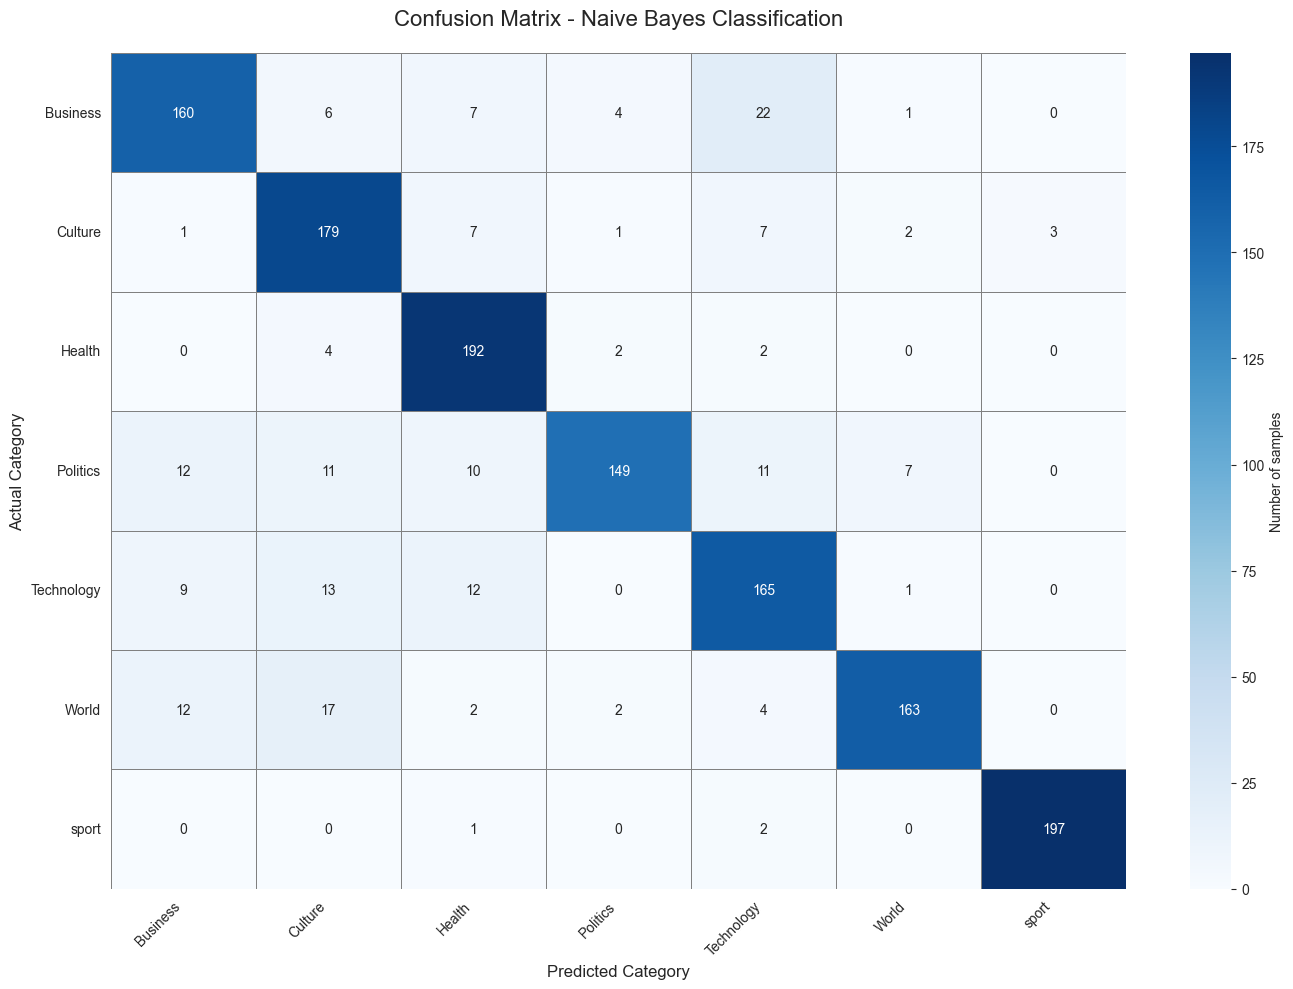

In [198]:
plot_confusion_matrix(y_test, predictions, title='Confusion Matrix - Naive Bayes Classification')


# LinearSVC


In [199]:
linear_svc_classifier = Pipeline([
    ('vectorizer', CountVectorizer(
        lowercase=True,
        token_pattern=r'\b[a-z]+\b',
        min_df=2,
        max_features=10000
    )),
    ('classifier', LinearSVC(random_state=42, max_iter=1000))
])

linear_svc_classifier.fit(X_train, y_train)

print("✓ Trained!")
print(f"Number of features (words): {len(linear_svc_classifier.named_steps['vectorizer'].vocabulary_)}")


✓ Trained!
Number of features (words): 10000


/opt/homebrew/lib/python3.9/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [200]:
svc_predictions = linear_svc_classifier.predict(X_test)

display_classification_metrics(y_test, svc_predictions)


,Category,Precision,Recall,F1-Score
0,Business,0.7228,0.7300,0.7264
1,Culture,0.7552,0.7250,0.7398
2,Health,0.8365,0.8700,0.8529
3,Politics,0.8034,0.7150,0.7566
4,Technology,0.6849,0.7500,0.7160
5,World,0.8513,0.8300,0.8405
6,sport,0.9515,0.9800,0.9655


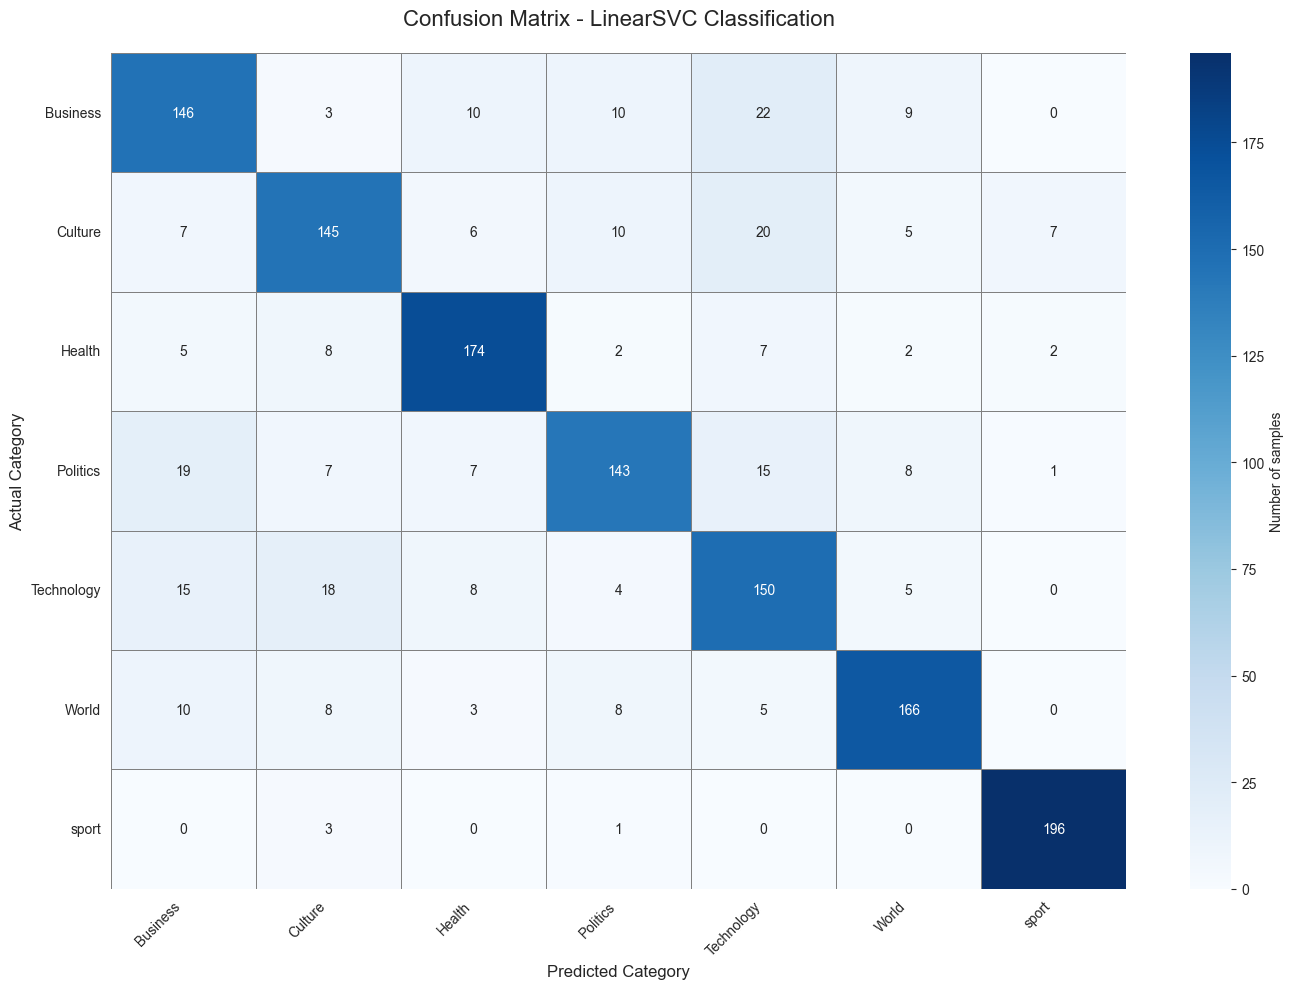

In [201]:
plot_confusion_matrix(y_test, svc_predictions, title='Confusion Matrix - LinearSVC Classification')

# Store results for comparison
results_storage = {
    'nb_count': {'predictions': predictions, 'accuracy': accuracy_score(y_test, predictions)},
    'svc_count': {'predictions': svc_predictions, 'accuracy': accuracy_score(y_test, svc_predictions)}
}


# TF-IDF and Word2Vec Comparison


## Naive Bayes with TfidfVectorizer


In [202]:
print("="*80)
print("NAIVE BAYES WITH TF-IDF VECTORIZER")
print("="*80)

nb_tfidf_classifier = Pipeline([
    ('vectorizer', TfidfVectorizer(
        lowercase=True,
        token_pattern=r'\b[a-z]+\b',
        min_df=2,
        max_features=10000
    )),
    ('classifier', MultinomialNB(alpha=1.0))
])

nb_tfidf_classifier.fit(X_train, y_train)
nb_tfidf_predictions = nb_tfidf_classifier.predict(X_test)

nb_tfidf_accuracy = accuracy_score(y_test, nb_tfidf_predictions) * 100
print(f"\n✓ Trained!")
print(f"Accuracy: {nb_tfidf_accuracy:.2f}%")
print(f"Number of features: {len(nb_tfidf_classifier.named_steps['vectorizer'].vocabulary_)}")

results_storage['nb_tfidf'] = {
    'predictions': nb_tfidf_predictions,
    'accuracy': accuracy_score(y_test, nb_tfidf_predictions)
}

display_classification_metrics(y_test, nb_tfidf_predictions, 'Naive Bayes (TF-IDF)')


NAIVE BAYES WITH TF-IDF VECTORIZER

✓ Trained!
Accuracy: 85.86%
Number of features: 10000


,Category,Precision,Recall,F1-Score
0,Business,0.8200,0.8200,0.8200
1,Culture,0.7877,0.8350,0.8107
2,Health,0.8101,0.9600,0.8787
3,Politics,0.9226,0.7750,0.8424
4,Technology,0.8112,0.7950,0.8030
5,World,0.9076,0.8350,0.8698
6,sport,0.9754,0.9900,0.9826


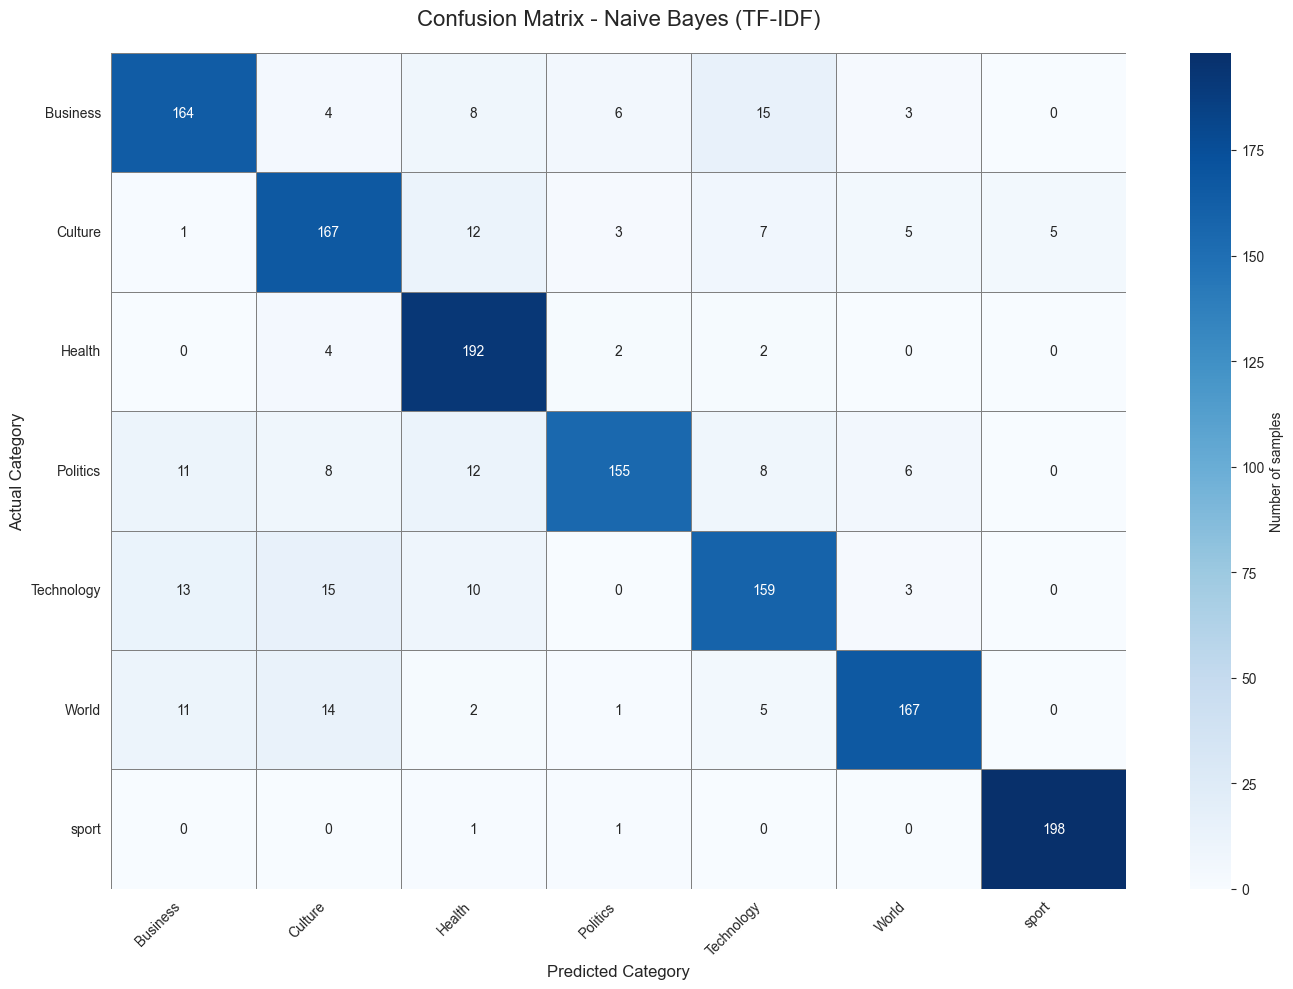

In [203]:
plot_confusion_matrix(y_test, nb_tfidf_predictions, title='Confusion Matrix - Naive Bayes (TF-IDF)')


## LinearSVC with TfidfVectorizer


In [204]:
print("="*80)
print("LINEAR SVC WITH TF-IDF VECTORIZER")
print("="*80)

svc_tfidf_classifier = Pipeline([
    ('vectorizer', TfidfVectorizer(
        lowercase=True,
        token_pattern=r'\b[a-z]+\b',
        min_df=2,
        max_features=10000
    )),
    ('classifier', LinearSVC(random_state=42, max_iter=2000))
])

svc_tfidf_classifier.fit(X_train, y_train)
svc_tfidf_predictions = svc_tfidf_classifier.predict(X_test)

svc_tfidf_accuracy = accuracy_score(y_test, svc_tfidf_predictions) * 100
print(f"\n✓ Trained!")
print(f"Accuracy: {svc_tfidf_accuracy:.2f}%")
print(f"Number of features: {len(svc_tfidf_classifier.named_steps['vectorizer'].vocabulary_)}")

results_storage['svc_tfidf'] = {
    'predictions': svc_tfidf_predictions,
    'accuracy': accuracy_score(y_test, svc_tfidf_predictions)
}

display_classification_metrics(y_test, svc_tfidf_predictions, 'LinearSVC (TF-IDF)')


LINEAR SVC WITH TF-IDF VECTORIZER

✓ Trained!
Accuracy: 86.36%
Number of features: 10000


,Category,Precision,Recall,F1-Score
0,Business,0.8281,0.7950,0.8112
1,Culture,0.8450,0.8450,0.8450
2,Health,0.8551,0.9150,0.8841
3,Politics,0.8833,0.7950,0.8368
4,Technology,0.7840,0.8350,0.8087
5,World,0.8918,0.8650,0.8782
6,sport,0.9614,0.9950,0.9779


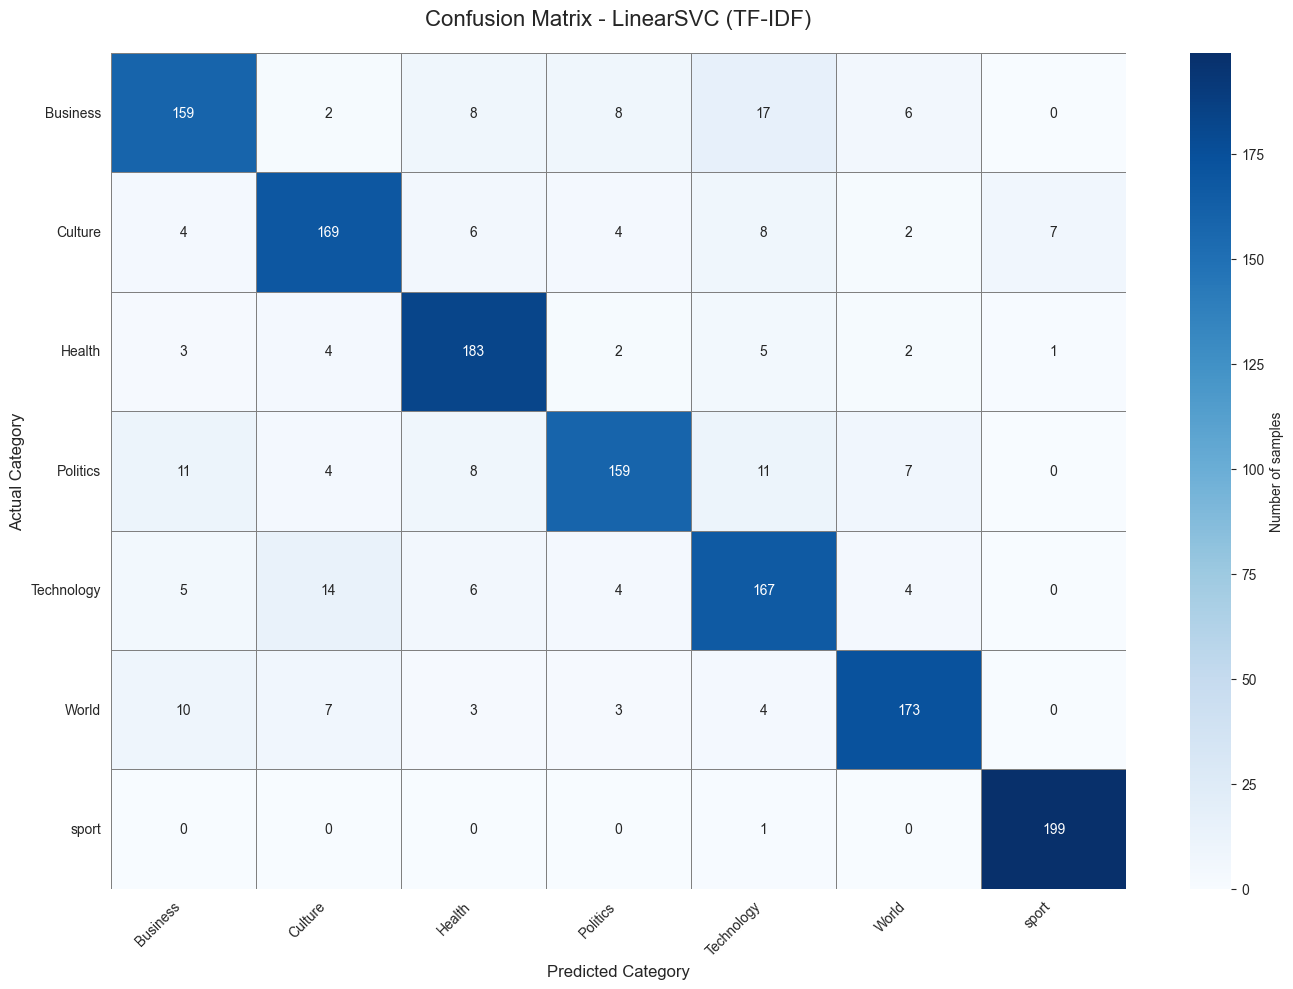

In [205]:
plot_confusion_matrix(y_test, svc_tfidf_predictions, title='Confusion Matrix - LinearSVC (TF-IDF)')


## Word2Vec Implementation


In [206]:
print("="*80)
print("PREPARING WORD2VEC EMBEDDINGS")
print("="*80)

# Tokenize texts for Word2Vec
print("Tokenizing texts...")
tokenized_train = [text.lower().split() for text in X_train]
tokenized_test = [text.lower().split() for text in X_test]

# Train Word2Vec model
print("Training Word2Vec model...")
w2v_model = Word2Vec(
    sentences=tokenized_train,
    vector_size=100,
    window=5,
    min_count=2,
    workers=4,
    sg=0,  # CBOW
    epochs=10
)

print(f"✓ Word2Vec model trained!")
print(f"Vocabulary size: {len(w2v_model.wv.key_to_index)}")

# Convert texts to vectors (average word embeddings)
def text_to_vector(text_tokens, model):
    """Convert tokenized text to vector by averaging word embeddings"""
    vectors = []
    for word in text_tokens:
        if word in model.wv:
            vectors.append(model.wv[word])
    
    if len(vectors) == 0:
        return np.zeros(model.vector_size)
    return np.mean(vectors, axis=0)

print("Converting texts to vectors...")
X_train_w2v = np.array([text_to_vector(text, w2v_model) for text in tokenized_train])
X_test_w2v = np.array([text_to_vector(text, w2v_model) for text in tokenized_test])

print(f"✓ Conversion complete!")
print(f"Training vectors shape: {X_train_w2v.shape}")
print(f"Test vectors shape: {X_test_w2v.shape}")


PREPARING WORD2VEC EMBEDDINGS
Tokenizing texts...
Training Word2Vec model...


Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'


✓ Word2Vec model trained!
Vocabulary size: 77687
Converting texts to vectors...
✓ Conversion complete!
Training vectors shape: (5600, 100)
Test vectors shape: (1400, 100)


## Naive Bayes with Word2Vec (GaussianNB)


In [207]:
print("="*80)
print("NAIVE BAYES (GAUSSIAN) WITH WORD2VEC")
print("="*80)

nb_w2v_classifier = GaussianNB()
nb_w2v_classifier.fit(X_train_w2v, y_train)
nb_w2v_predictions = nb_w2v_classifier.predict(X_test_w2v)

nb_w2v_accuracy = accuracy_score(y_test, nb_w2v_predictions) * 100

results_storage['nb_w2v'] = {
    'predictions': nb_w2v_predictions,
    'accuracy': accuracy_score(y_test, nb_w2v_predictions)
}

display_classification_metrics(y_test, nb_w2v_predictions, 'Naive Bayes (Word2Vec)')


NAIVE BAYES (GAUSSIAN) WITH WORD2VEC


,Category,Precision,Recall,F1-Score
0,Business,0.6684,0.6350,0.6513
1,Culture,0.6626,0.8050,0.7269
2,Health,0.6597,0.7850,0.7169
3,Politics,0.8141,0.6350,0.7135
4,Technology,0.6425,0.5750,0.6069
5,World,0.7535,0.8100,0.7807
6,sport,1.0000,0.8950,0.9446


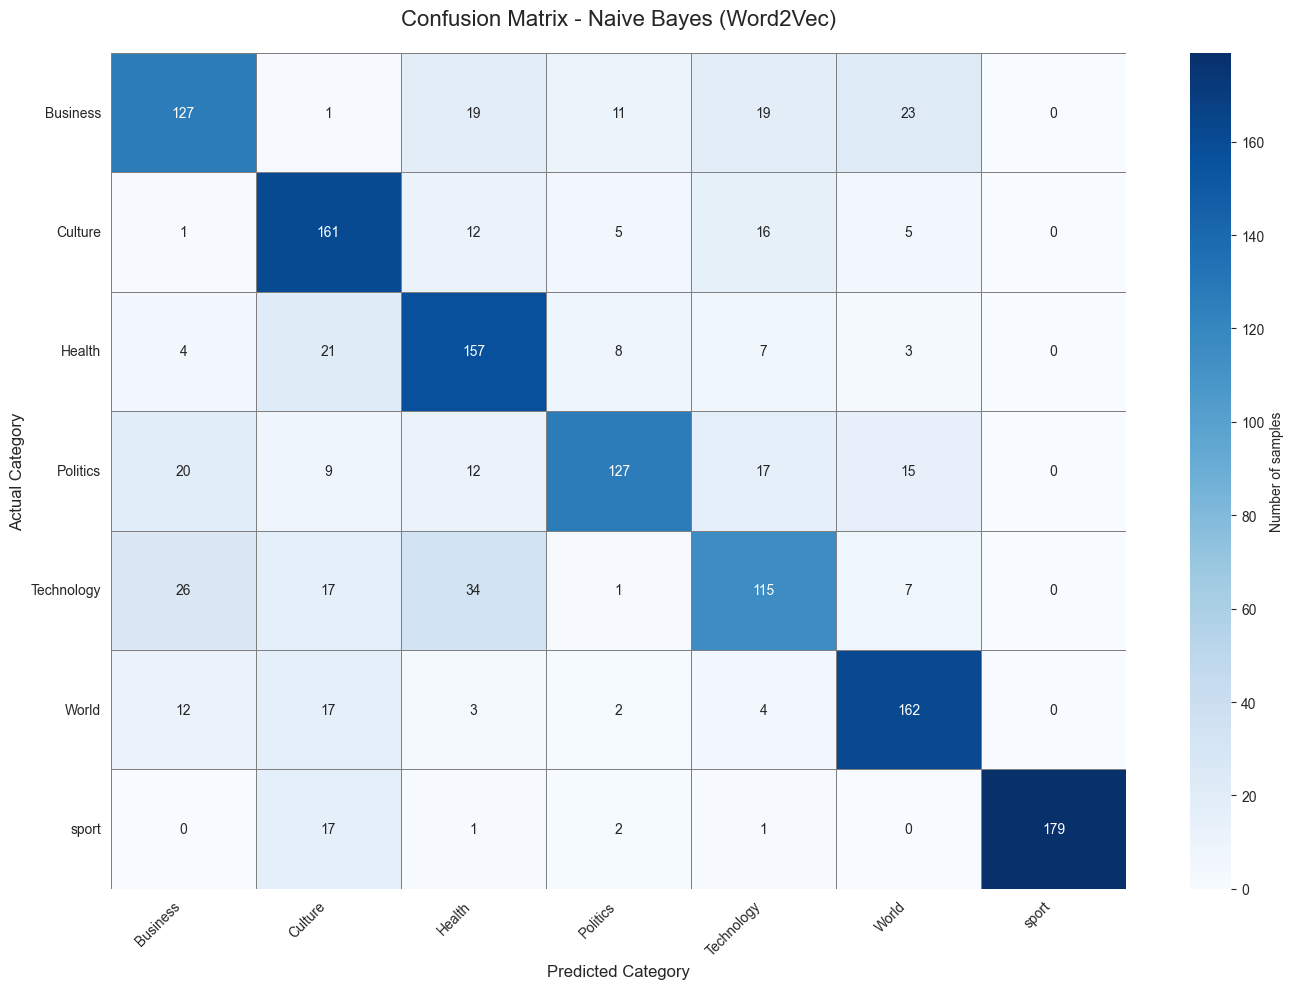

In [208]:
plot_confusion_matrix(y_test, nb_w2v_predictions, title='Confusion Matrix - Naive Bayes (Word2Vec)')


## LinearSVC with Word2Vec


In [209]:
print("LINEAR SVC WITH WORD2VEC")

svc_w2v_classifier = LinearSVC(random_state=42, max_iter=2000)
svc_w2v_classifier.fit(X_train_w2v, y_train)
svc_w2v_predictions = svc_w2v_classifier.predict(X_test_w2v)

svc_w2v_accuracy = accuracy_score(y_test, svc_w2v_predictions) * 100

results_storage['svc_w2v'] = {
    'predictions': svc_w2v_predictions,
    'accuracy': accuracy_score(y_test, svc_w2v_predictions)
}

display_classification_metrics(y_test, svc_w2v_predictions, 'LinearSVC (Word2Vec)')


LINEAR SVC WITH WORD2VEC


,Category,Precision,Recall,F1-Score
0,Business,0.7861,0.6800,0.7292
1,Culture,0.8308,0.8100,0.8203
2,Health,0.8341,0.8800,0.8564
3,Politics,0.8392,0.8350,0.8371
4,Technology,0.7356,0.7650,0.7500
5,World,0.8708,0.9100,0.8900
6,sport,0.9659,0.9900,0.9778


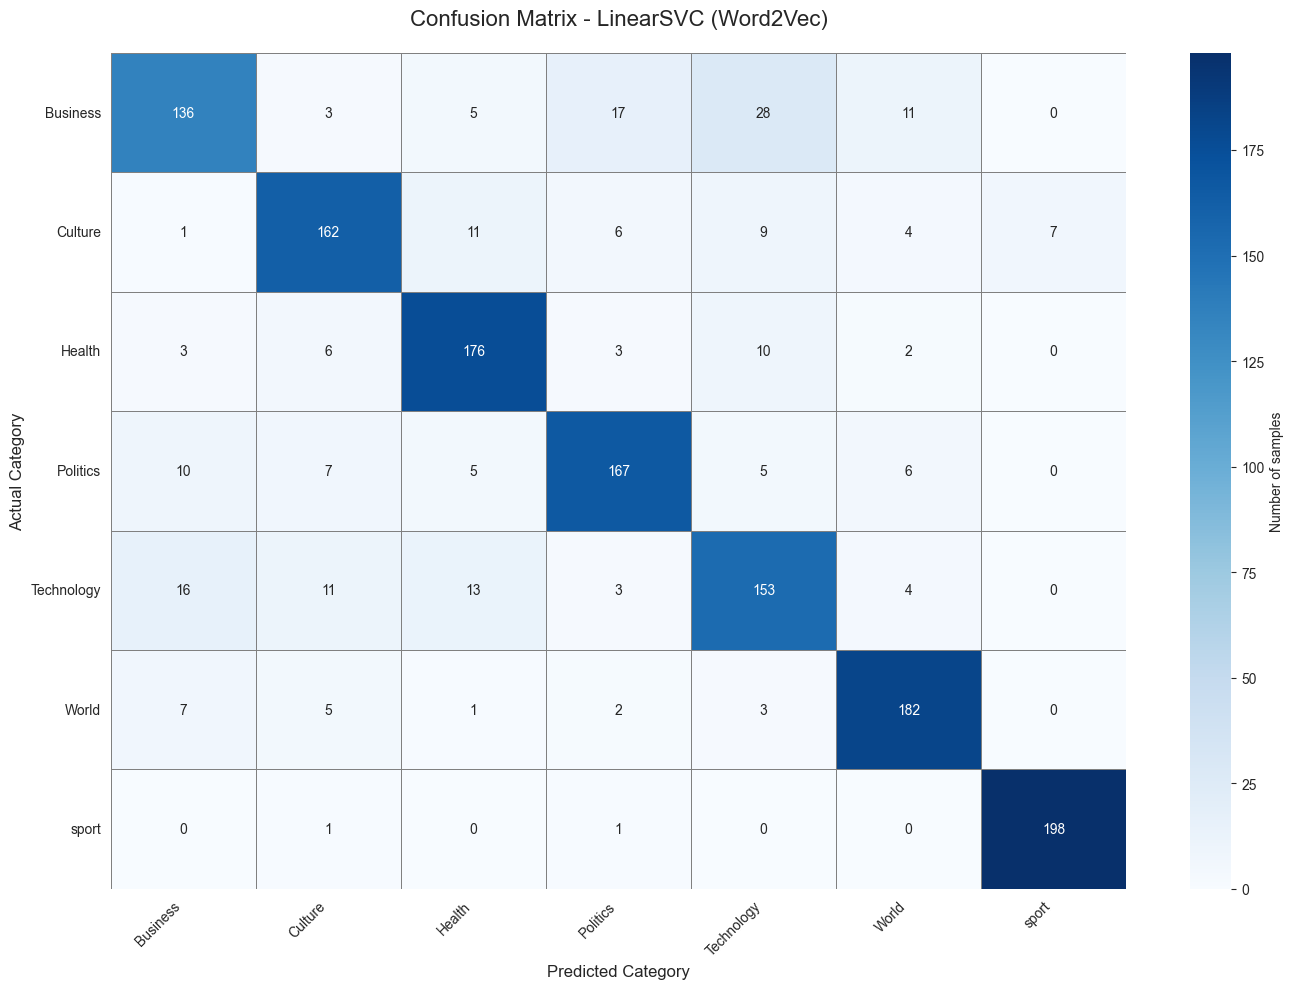

In [210]:
plot_confusion_matrix(y_test, svc_w2v_predictions, title='Confusion Matrix - LinearSVC (Word2Vec)')


## Comprehensive Comparison


,Vectorizer,Accuracy (%),Model
0,CountVectorizer,86.07%,MultinomialNB
1,TfidfVectorizer,85.86%,MultinomialNB
2,Word2Vec,73.43%,GaussianNB


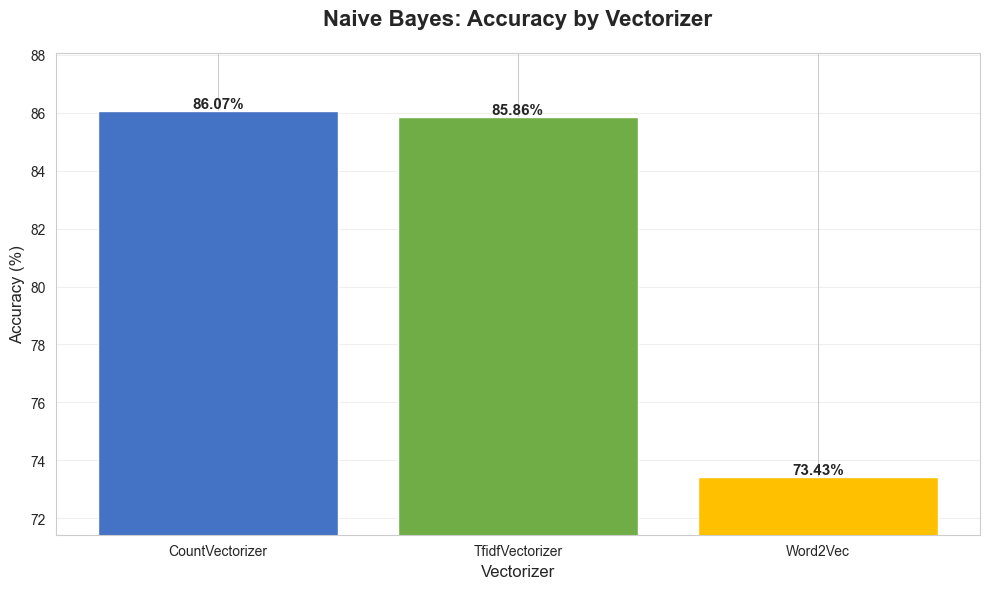

In [211]:
nb_comparison_data = {
    'Vectorizer': ['CountVectorizer', 'TfidfVectorizer', 'Word2Vec'],
    'Accuracy (%)': [
        results_storage['nb_count']['accuracy'] * 100,
        results_storage['nb_tfidf']['accuracy'] * 100,
        results_storage['nb_w2v']['accuracy'] * 100
    ],
    'Model': ['MultinomialNB', 'MultinomialNB', 'GaussianNB']
}

nb_comparison_df = pd.DataFrame(nb_comparison_data)
nb_comparison_df = nb_comparison_df.sort_values('Accuracy (%)', ascending=False)

styled_nb = nb_comparison_df.style.format({
    'Accuracy (%)': '{:.2f}%'
}).background_gradient(subset=['Accuracy (%)'], cmap='YlGnBu', vmin=nb_comparison_df['Accuracy (%)'].min(), 
                      vmax=nb_comparison_df['Accuracy (%)'].max()).set_caption(
    'Naive Bayes: Vectorizer Comparison').set_table_styles([
    {'selector': 'caption', 'props': [('font-size', '16px'), ('font-weight', 'bold'), ('text-align', 'center')]},
    {'selector': 'th', 'props': [('background-color', '#4472C4'), ('color', 'white'), ('font-weight', 'bold'), ('text-align', 'center')]},
    {'selector': 'td', 'props': [('text-align', 'center')]}
])

display(styled_nb)

# Visualization
plt.figure(figsize=(10, 6))
colors = ['#4472C4', '#70AD47', '#FFC000']
bars = plt.bar(nb_comparison_df['Vectorizer'], nb_comparison_df['Accuracy (%)'], color=colors)
plt.title('Naive Bayes: Accuracy by Vectorizer', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.xlabel('Vectorizer', fontsize=12)
plt.ylim([min(nb_comparison_df['Accuracy (%)']) - 2, max(nb_comparison_df['Accuracy (%)']) + 2])
plt.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}%',
             ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()


COMPREHENSIVE COMPARISON: LINEAR SVC


,Vectorizer,Accuracy (%),Model
1,TfidfVectorizer,86.36%,LinearSVC
2,Word2Vec,83.86%,LinearSVC
0,CountVectorizer,80.00%,LinearSVC


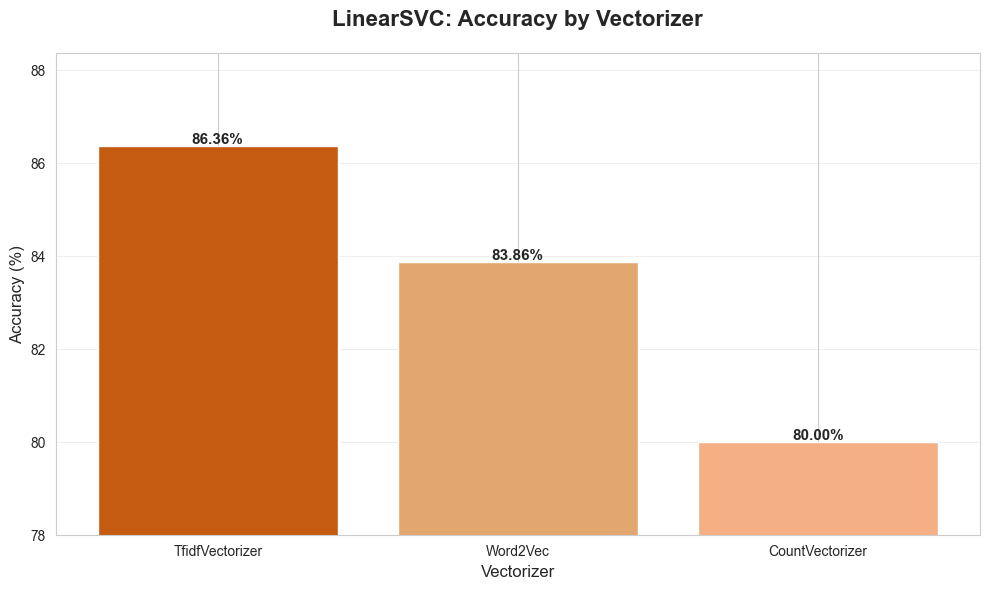

In [212]:
print("="*80)
print("COMPREHENSIVE COMPARISON: LINEAR SVC")
print("="*80)

svc_comparison_data = {
    'Vectorizer': ['CountVectorizer', 'TfidfVectorizer', 'Word2Vec'],
    'Accuracy (%)': [
        results_storage['svc_count']['accuracy'] * 100,
        results_storage['svc_tfidf']['accuracy'] * 100,
        results_storage['svc_w2v']['accuracy'] * 100
    ],
    'Model': ['LinearSVC', 'LinearSVC', 'LinearSVC']
}

svc_comparison_df = pd.DataFrame(svc_comparison_data)
svc_comparison_df = svc_comparison_df.sort_values('Accuracy (%)', ascending=False)

styled_svc = svc_comparison_df.style.format({
    'Accuracy (%)': '{:.2f}%'
}).background_gradient(subset=['Accuracy (%)'], cmap='YlOrRd', vmin=svc_comparison_df['Accuracy (%)'].min(), 
                      vmax=svc_comparison_df['Accuracy (%)'].max()).set_caption(
    'LinearSVC: Vectorizer Comparison').set_table_styles([
    {'selector': 'caption', 'props': [('font-size', '16px'), ('font-weight', 'bold'), ('text-align', 'center')]},
    {'selector': 'th', 'props': [('background-color', '#C55A11'), ('color', 'white'), ('font-weight', 'bold'), ('text-align', 'center')]},
    {'selector': 'td', 'props': [('text-align', 'center')]}
])

display(styled_svc)

# Visualization
plt.figure(figsize=(10, 6))
colors = ['#C55A11', '#E2A76F', '#F4B084']
bars = plt.bar(svc_comparison_df['Vectorizer'], svc_comparison_df['Accuracy (%)'], color=colors)
plt.title('LinearSVC: Accuracy by Vectorizer', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.xlabel('Vectorizer', fontsize=12)
plt.ylim([min(svc_comparison_df['Accuracy (%)']) - 2, max(svc_comparison_df['Accuracy (%)']) + 2])
plt.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}%',
             ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()


In [213]:
print("="*80)
print("NAIVE BAYES vs LINEAR SVC: COMPARISON BY VECTORIZER")
print("="*80)

# CountVectorizer comparison
count_comparison = {
    'Model': ['Naive Bayes', 'LinearSVC'],
    'Vectorizer': ['CountVectorizer', 'CountVectorizer'],
    'Accuracy (%)': [
        results_storage['nb_count']['accuracy'] * 100,
        results_storage['svc_count']['accuracy'] * 100
    ]
}

# TfidfVectorizer comparison
tfidf_comparison = {
    'Model': ['Naive Bayes', 'LinearSVC'],
    'Vectorizer': ['TfidfVectorizer', 'TfidfVectorizer'],
    'Accuracy (%)': [
        results_storage['nb_tfidf']['accuracy'] * 100,
        results_storage['svc_tfidf']['accuracy'] * 100
    ]
}

# Word2Vec comparison
w2v_comparison = {
    'Model': ['Naive Bayes', 'LinearSVC'],
    'Vectorizer': ['Word2Vec', 'Word2Vec'],
    'Accuracy (%)': [
        results_storage['nb_w2v']['accuracy'] * 100,
        results_storage['svc_w2v']['accuracy'] * 100
    ]
}

count_df = pd.DataFrame(count_comparison)
tfidf_df = pd.DataFrame(tfidf_comparison)
w2v_df = pd.DataFrame(w2v_comparison)

# Display all comparisons
print("\n1. CountVectorizer Comparison:")
styled_count = count_df.style.format({
    'Accuracy (%)': '{:.2f}%'
}).background_gradient(subset=['Accuracy (%)'], cmap='Blues', vmin=count_df['Accuracy (%)'].min(), 
                      vmax=count_df['Accuracy (%)'].max()).set_caption(
    'CountVectorizer: Naive Bayes vs LinearSVC').set_table_styles([
    {'selector': 'caption', 'props': [('font-size', '14px'), ('font-weight', 'bold'), ('text-align', 'center')]},
    {'selector': 'th', 'props': [('background-color', '#4472C4'), ('color', 'white'), ('font-weight', 'bold'), ('text-align', 'center')]},
    {'selector': 'td', 'props': [('text-align', 'center')]}
])
display(styled_count)

print("\n2. TfidfVectorizer Comparison:")
styled_tfidf = tfidf_df.style.format({
    'Accuracy (%)': '{:.2f}%'
}).background_gradient(subset=['Accuracy (%)'], cmap='Greens', vmin=tfidf_df['Accuracy (%)'].min(), 
                      vmax=tfidf_df['Accuracy (%)'].max()).set_caption(
    'TfidfVectorizer: Naive Bayes vs LinearSVC').set_table_styles([
    {'selector': 'caption', 'props': [('font-size', '14px'), ('font-weight', 'bold'), ('text-align', 'center')]},
    {'selector': 'th', 'props': [('background-color', '#70AD47'), ('color', 'white'), ('font-weight', 'bold'), ('text-align', 'center')]},
    {'selector': 'td', 'props': [('text-align', 'center')]}
])
display(styled_tfidf)

print("\n3. Word2Vec Comparison:")
styled_w2v = w2v_df.style.format({
    'Accuracy (%)': '{:.2f}%'
}).background_gradient(subset=['Accuracy (%)'], cmap='Oranges', vmin=w2v_df['Accuracy (%)'].min(), 
                      vmax=w2v_df['Accuracy (%)'].max()).set_caption(
    'Word2Vec: Naive Bayes vs LinearSVC').set_table_styles([
    {'selector': 'caption', 'props': [('font-size', '14px'), ('font-weight', 'bold'), ('text-align', 'center')]},
    {'selector': 'th', 'props': [('background-color', '#FFC000'), ('color', 'white'), ('font-weight', 'bold'), ('text-align', 'center')]},
    {'selector': 'td', 'props': [('text-align', 'center')]}
])
display(styled_w2v)


NAIVE BAYES vs LINEAR SVC: COMPARISON BY VECTORIZER

1. CountVectorizer Comparison:


,Model,Vectorizer,Accuracy (%)
0,Naive Bayes,CountVectorizer,86.07%
1,LinearSVC,CountVectorizer,80.00%



2. TfidfVectorizer Comparison:


,Model,Vectorizer,Accuracy (%)
0,Naive Bayes,TfidfVectorizer,85.86%
1,LinearSVC,TfidfVectorizer,86.36%



3. Word2Vec Comparison:


,Model,Vectorizer,Accuracy (%)
0,Naive Bayes,Word2Vec,73.43%
1,LinearSVC,Word2Vec,83.86%


In [214]:
# Combined summary table
summary_data = []
for vectorizer_name, vectorizer_key in [('CountVectorizer', 'count'), 
                                         ('TfidfVectorizer', 'tfidf'), 
                                         ('Word2Vec', 'w2v')]:
    summary_data.append({
        'Vectorizer': vectorizer_name,
        'Naive Bayes Accuracy (%)': results_storage[f'nb_{vectorizer_key}']['accuracy'] * 100,
        'LinearSVC Accuracy (%)': results_storage[f'svc_{vectorizer_key}']['accuracy'] * 100,
        'Winner': 'Naive Bayes' if results_storage[f'nb_{vectorizer_key}']['accuracy'] > results_storage[f'svc_{vectorizer_key}']['accuracy'] else 'LinearSVC',
        'Difference (%)': abs(results_storage[f'nb_{vectorizer_key}']['accuracy'] - results_storage[f'svc_{vectorizer_key}']['accuracy']) * 100
    })

summary_df = pd.DataFrame(summary_data)

styled_summary = summary_df.style.format({
    'Naive Bayes Accuracy (%)': '{:.2f}%',
    'LinearSVC Accuracy (%)': '{:.2f}%',
    'Difference (%)': '{:.2f}%'
}).background_gradient(subset=['Naive Bayes Accuracy (%)', 'LinearSVC Accuracy (%)'], 
                      cmap='YlGnBu', vmin=summary_df[['Naive Bayes Accuracy (%)', 'LinearSVC Accuracy (%)']].min().min(),
                      vmax=summary_df[['Naive Bayes Accuracy (%)', 'LinearSVC Accuracy (%)']].max().max()).set_caption(
    'Complete Summary: Naive Bayes vs LinearSVC by Vectorizer').set_table_styles([
    {'selector': 'caption', 'props': [('font-size', '16px'), ('font-weight', 'bold'), ('text-align', 'center'), ('padding', '10px')]},
    {'selector': 'th', 'props': [('background-color', '#2E75B6'), ('color', 'white'), ('font-weight', 'bold'), ('text-align', 'center'), ('padding', '10px')]},
    {'selector': 'td', 'props': [('text-align', 'center'), ('padding', '8px')]}
]).apply(lambda x: ['background-color: #90EE90' if x['Winner'] == 'Naive Bayes' else 'background-color: #FFB6C1' 
                    for _ in x], axis=1, subset=['Winner'])

display(styled_summary)


,Vectorizer,Naive Bayes Accuracy (%),LinearSVC Accuracy (%),Winner,Difference (%)
0,CountVectorizer,86.07%,80.00%,Naive Bayes,6.07%
1,TfidfVectorizer,85.86%,86.36%,LinearSVC,0.50%
2,Word2Vec,73.43%,83.86%,LinearSVC,10.43%


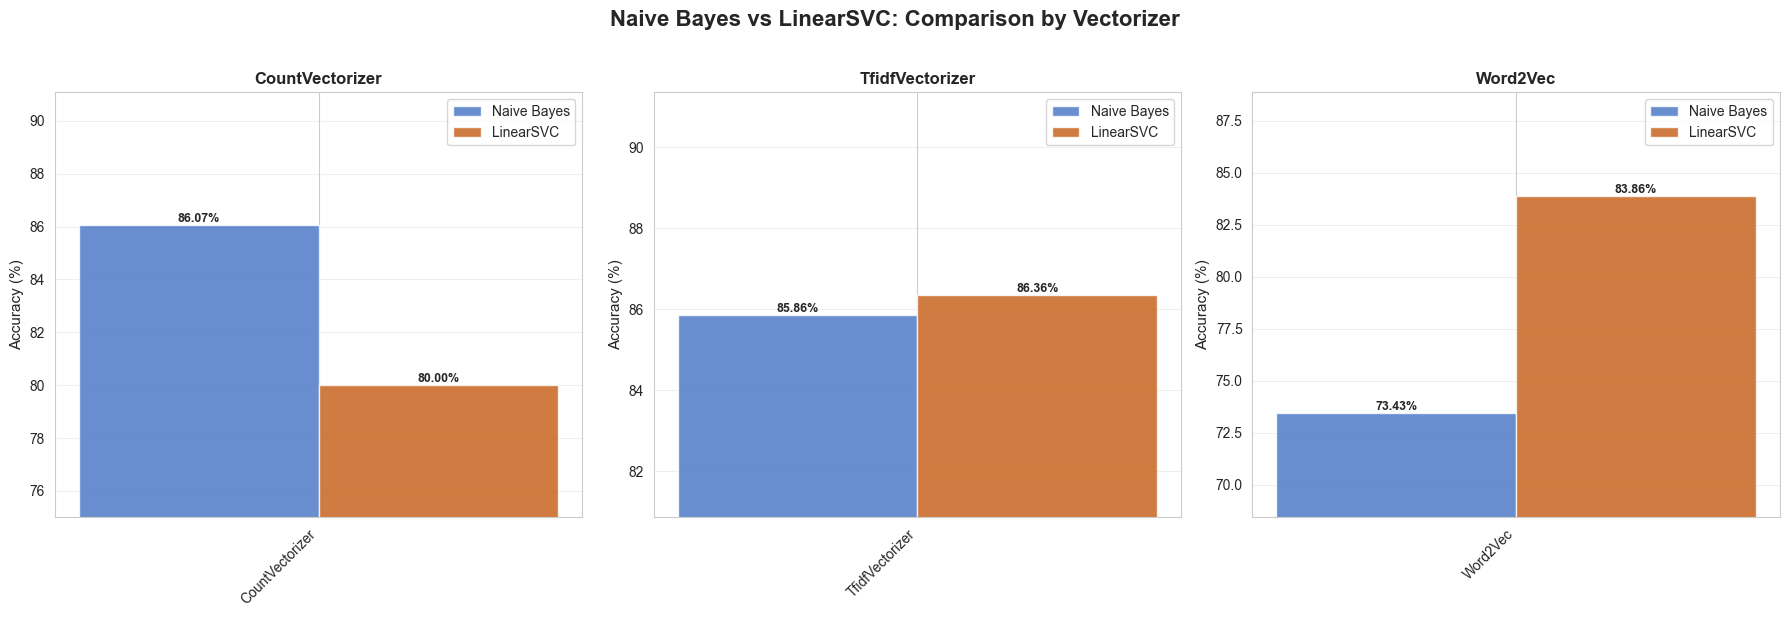

In [215]:
# Visual comparison: Side-by-side bar chart
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

vectorizers = ['CountVectorizer', 'TfidfVectorizer', 'Word2Vec']
nb_accuracies = [
    results_storage['nb_count']['accuracy'] * 100,
    results_storage['nb_tfidf']['accuracy'] * 100,
    results_storage['nb_w2v']['accuracy'] * 100
]
svc_accuracies = [
    results_storage['svc_count']['accuracy'] * 100,
    results_storage['svc_tfidf']['accuracy'] * 100,
    results_storage['svc_w2v']['accuracy'] * 100
]

x = np.arange(len(vectorizers))
width = 0.35

for idx, (vec, nb_acc, svc_acc) in enumerate(zip(vectorizers, nb_accuracies, svc_accuracies)):
    axes[idx].bar(x[idx] - width/2, nb_acc, width, label='Naive Bayes', color='#4472C4', alpha=0.8)
    axes[idx].bar(x[idx] + width/2, svc_acc, width, label='LinearSVC', color='#C55A11', alpha=0.8)
    axes[idx].set_ylabel('Accuracy (%)', fontsize=11)
    axes[idx].set_title(f'{vec}', fontsize=12, fontweight='bold')
    axes[idx].set_xticks([x[idx]])
    axes[idx].set_xticklabels([vec], rotation=45, ha='right')
    axes[idx].set_ylim([min(nb_acc, svc_acc) - 5, max(nb_acc, svc_acc) + 5])
    axes[idx].grid(axis='y', alpha=0.3)
    axes[idx].legend()
    
    # Add value labels
    axes[idx].text(x[idx] - width/2, nb_acc, f'{nb_acc:.2f}%', 
                   ha='center', va='bottom', fontsize=9, fontweight='bold')
    axes[idx].text(x[idx] + width/2, svc_acc, f'{svc_acc:.2f}%', 
                   ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.suptitle('Naive Bayes vs LinearSVC: Comparison by Vectorizer', 
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


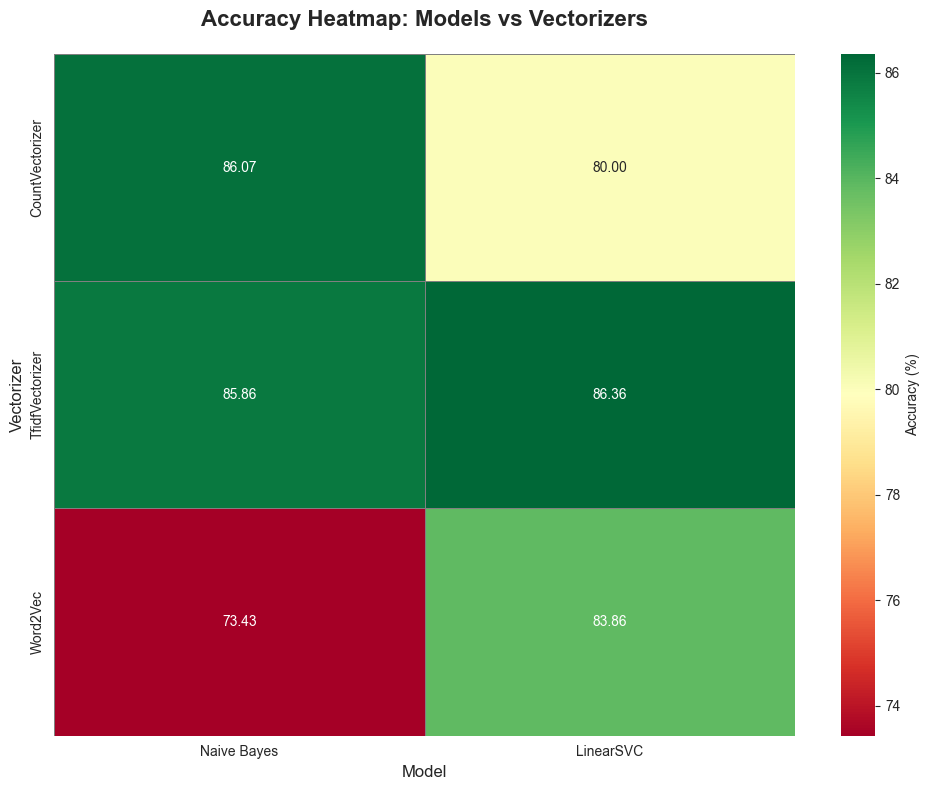

In [216]:
# Overall comparison heatmap
comparison_matrix = np.array([
    [results_storage['nb_count']['accuracy'] * 100, results_storage['svc_count']['accuracy'] * 100],
    [results_storage['nb_tfidf']['accuracy'] * 100, results_storage['svc_tfidf']['accuracy'] * 100],
    [results_storage['nb_w2v']['accuracy'] * 100, results_storage['svc_w2v']['accuracy'] * 100]
])

plt.figure(figsize=(10, 8))
sns.heatmap(
    comparison_matrix,
    annot=True,
    fmt='.2f',
    cmap='RdYlGn',
    xticklabels=['Naive Bayes', 'LinearSVC'],
    yticklabels=['CountVectorizer', 'TfidfVectorizer', 'Word2Vec'],
    cbar_kws={'label': 'Accuracy (%)'},
    linewidths=0.5,
    linecolor='gray',
    vmin=comparison_matrix.min(),
    vmax=comparison_matrix.max()
)
plt.title('Accuracy Heatmap: Models vs Vectorizers', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Model', fontsize=12)
plt.ylabel('Vectorizer', fontsize=12)
plt.tight_layout()
plt.show()


# CNN (Conv1D)


In [217]:
print("="*80)
print("CNN (CONV1D) CLASSIFIER FOR TEXT")
print("="*80)
print("\nPreparing data for CNN...")

max_words = 10000
max_len = 500

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_padded = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=max_len, padding='post', truncating='post')

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

num_classes = len(np.unique(y_train_encoded))
y_train_categorical = to_categorical(y_train_encoded, num_classes=num_classes)
y_test_categorical = to_categorical(y_test_encoded, num_classes=num_classes)

print(f"Vocabulary size: {max_words}")
print(f"Sequence length: {max_len}")
print(f"Number of classes: {num_classes}")
print(f"Training samples: {len(X_train_padded)}")
print(f"Test samples: {len(X_test_padded)}")


CNN (CONV1D) CLASSIFIER FOR TEXT

Preparing data for CNN...
Vocabulary size: 10000
Sequence length: 500
Number of classes: 7
Training samples: 5600
Test samples: 1400


In [218]:
embedding_dim = 128

cnn_model = Sequential([
    Embedding(max_words, embedding_dim, input_length=max_len),
    Conv1D(128, 5, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

cnn_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


/opt/homebrew/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [219]:
print("\nTraining CNN classifier...")

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

history = cnn_model.fit(
    X_train_padded, y_train_categorical,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

print("✓ Trained!")



Training CNN classifier...
Epoch 1/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.2161 - loss: 1.8939 - val_accuracy: 0.5277 - val_loss: 1.3265
Epoch 2/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.5766 - loss: 1.1965 - val_accuracy: 0.7071 - val_loss: 0.8898
Epoch 3/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.7477 - loss: 0.7640 - val_accuracy: 0.7563 - val_loss: 0.6785
Epoch 4/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.8608 - loss: 0.4729 - val_accuracy: 0.7804 - val_loss: 0.6126
Epoch 5/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - accuracy: 0.9402 - loss: 0.2578 - val_accuracy: 0.7911 - val_loss: 0.6002
Epoch 6/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.9714 - loss: 0.1334 - val_accuracy: 0.8036 - val_loss: 0.6156
Epoch 7/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - accuracy: 0.9834 - loss: 0.0890 - val_accuracy: 0.7911 - val_loss: 0.6667
Epoch 8/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.99

In [220]:
cnn_predictions_proba = cnn_model.predict(X_test_padded, verbose=0)
cnn_predictions_encoded = np.argmax(cnn_predictions_proba, axis=1)
cnn_predictions = label_encoder.inverse_transform(cnn_predictions_encoded)

display_classification_metrics(y_test, cnn_predictions)


,Category,Precision,Recall,F1-Score
0,Business,0.6584,0.8000,0.7223
1,Culture,0.7514,0.6950,0.7221
2,Health,0.8073,0.8800,0.8421
3,Politics,0.8642,0.7000,0.7735
4,Technology,0.7404,0.7700,0.7549
5,World,0.8715,0.7800,0.8232
6,sport,0.9561,0.9800,0.9679


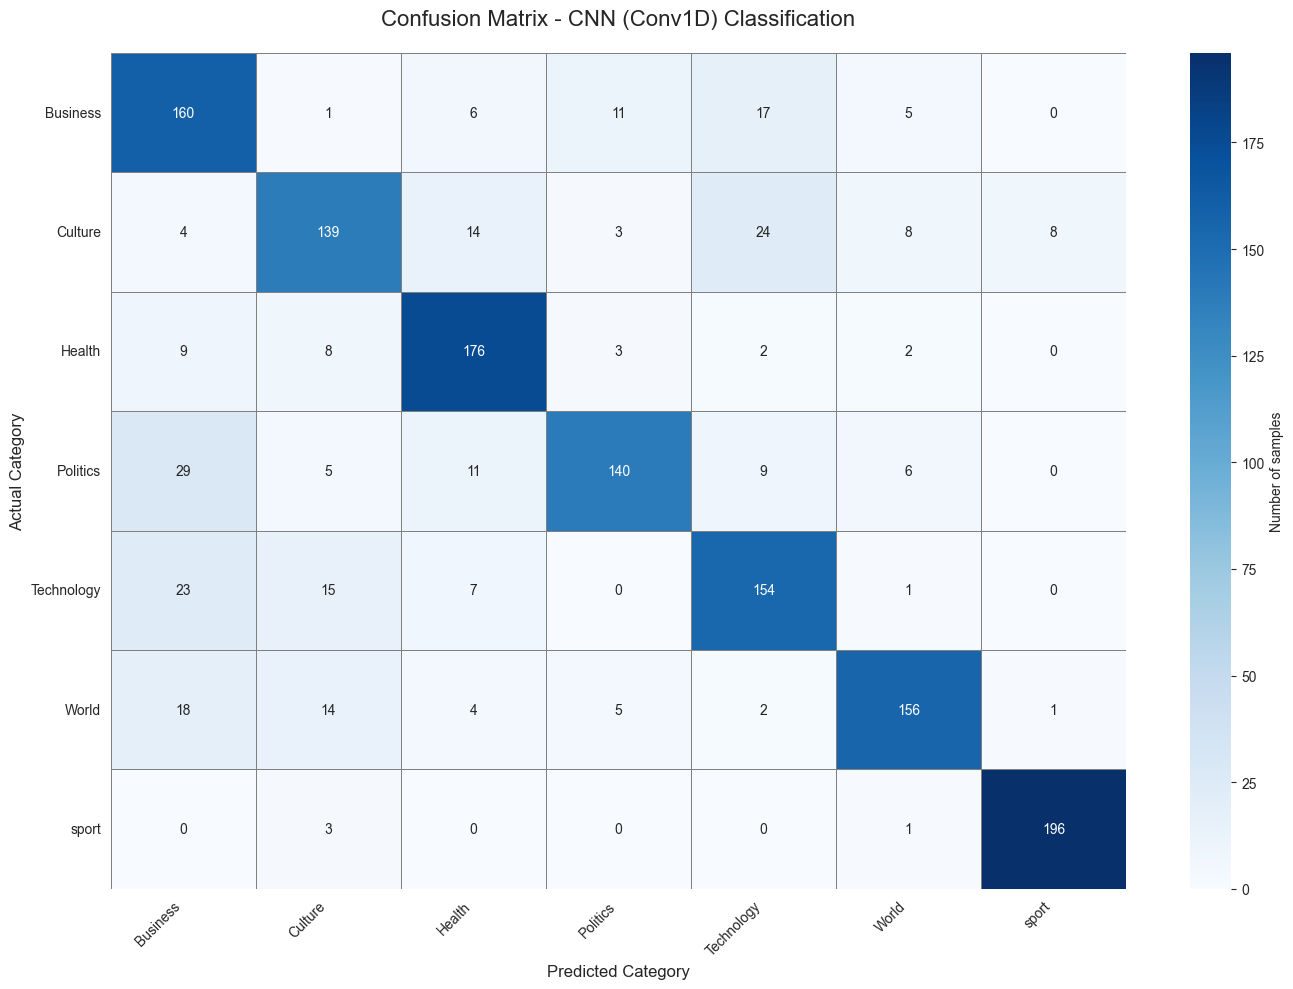

In [221]:
plot_confusion_matrix(y_test, cnn_predictions, title='Confusion Matrix - CNN (Conv1D) Classification')


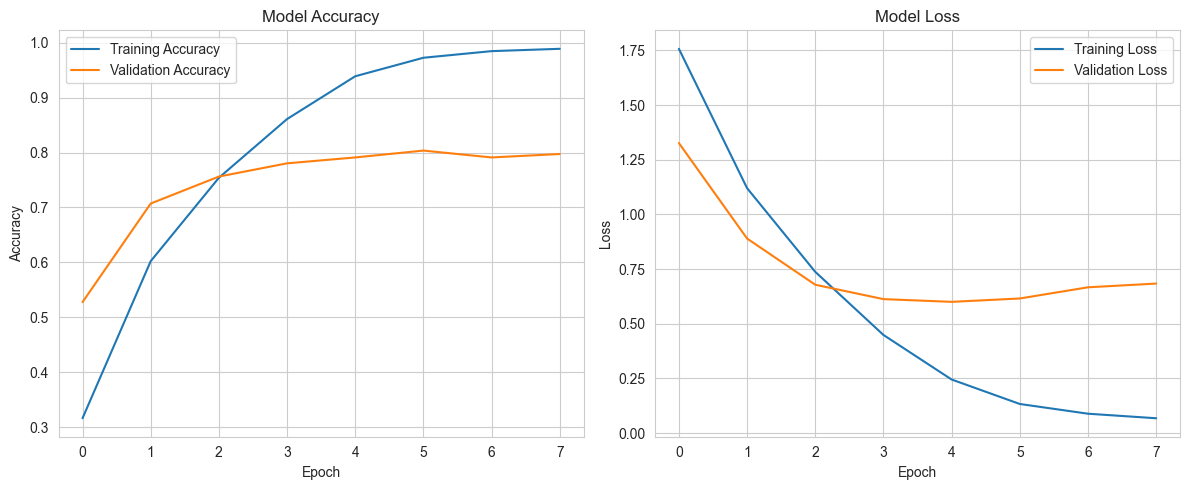

In [222]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


# Word Importance Analysis


In [223]:
print("="*80)
print("WORD IMPORTANCE ANALYSIS - NAIVE BAYES")
print("="*80)

vectorizer = classifier.named_steps['vectorizer']
nb_model = classifier.named_steps['classifier']
vocabulary = vectorizer.vocabulary_
feature_names = vectorizer.get_feature_names_out()

feature_log_prob = nb_model.feature_log_prob_
classes = nb_model.classes_

print(f"\nNumber of categories: {len(classes)}")
print(f"Number of words (features): {len(feature_names)}")

nb_top_words = {}
for i, category in enumerate(classes):
    other_categories_log_probs = np.mean(
        np.delete(feature_log_prob, i, axis=0), 
        axis=0
    )
    
    discriminative_scores = feature_log_prob[i] - other_categories_log_probs
    
    top_indices = np.argsort(discriminative_scores)[::-1][:3]
    top_words = [(feature_names[idx], discriminative_scores[idx]) for idx in top_indices]
    nb_top_words[category] = top_words

print("\n" + "="*80)
print("TOP 3 WORDS FOR EACH CATEGORY (Naive Bayes - discriminative measure):")
print("="*80)
for category in sorted(nb_top_words.keys()):
    print(f"\n{category.upper()}:")
    for word, score in nb_top_words[category]:
        print(f"  - {word:20s} (discriminative score: {score:.4f})")


WORD IMPORTANCE ANALYSIS - NAIVE BAYES

Number of categories: 7
Number of words (features): 10000

TOP 3 WORDS FOR EACH CATEGORY (Naive Bayes - discriminative measure):

BUSINESS:
  - boeing               (discriminative score: 4.9988)
  - tariffs              (discriminative score: 4.2706)
  - shein                (discriminative score: 4.2352)

CULTURE:
  - oasis                (discriminative score: 4.6009)
  - traitors             (discriminative score: 4.5692)
  - pelicot              (discriminative score: 4.5605)

HEALTH:
  - mounjaro             (discriminative score: 4.6032)
  - maternity            (discriminative score: 4.5538)
  - vaccines             (discriminative score: 4.5206)

POLITICS:
  - farage               (discriminative score: 5.0689)
  - badenoch             (discriminative score: 4.9805)
  - snp                  (discriminative score: 4.4638)

TECHNOLOGY:
  - deepseek             (discriminative score: 4.9938)
  - roblox               (discriminative score: 4

In [224]:
print("="*80)
print("WORD IMPORTANCE ANALYSIS - LINEAR SVC")
print("="*80)

svc_vectorizer = linear_svc_classifier.named_steps['vectorizer']
svc_model = linear_svc_classifier.named_steps['classifier']
svc_feature_names = svc_vectorizer.get_feature_names_out()

svc_coef = svc_model.coef_
svc_classes = svc_model.classes_

print(f"\nNumber of categories: {len(svc_classes)}")
print(f"Number of words (features): {len(svc_feature_names)}")

svc_top_words = {}
for i, category in enumerate(svc_classes):
    coefs = svc_coef[i]
    top_indices = np.argsort(coefs)[::-1][:3]
    top_words = [(svc_feature_names[idx], coefs[idx]) for idx in top_indices]
    svc_top_words[category] = top_words

print("\n" + "="*80)
print("TOP 3 WORDS FOR EACH CATEGORY (LinearSVC):")
print("="*80)
for category in sorted(svc_top_words.keys()):
    print(f"\n{category.upper()}:")
    for word, score in svc_top_words[category]:
        print(f"  - {word:20s} (coefficient: {score:.4f})")


WORD IMPORTANCE ANALYSIS - LINEAR SVC

Number of categories: 7
Number of words (features): 10000

TOP 3 WORDS FOR EACH CATEGORY (LinearSVC):

BUSINESS:
  - branch               (coefficient: 0.1604)
  - case                 (coefficient: 0.1573)
  - trains               (coefficient: 0.1418)

CULTURE:
  - singer               (coefficient: 0.3755)
  - cat                  (coefficient: 0.3151)
  - castle               (coefficient: 0.2620)

HEALTH:
  - avoiding             (coefficient: 0.4198)
  - fine                 (coefficient: 0.3466)
  - trapped              (coefficient: 0.2624)

POLITICS:
  - election             (coefficient: 0.1759)
  - windsor              (coefficient: 0.1752)
  - greeted              (coefficient: 0.1727)

TECHNOLOGY:
  - remembering          (coefficient: 0.5922)
  - vegetables           (coefficient: 0.5357)
  - angry                (coefficient: 0.3026)

WORLD:
  - nude                 (coefficient: 0.3679)
  - walking              (coefficient: 0.3670

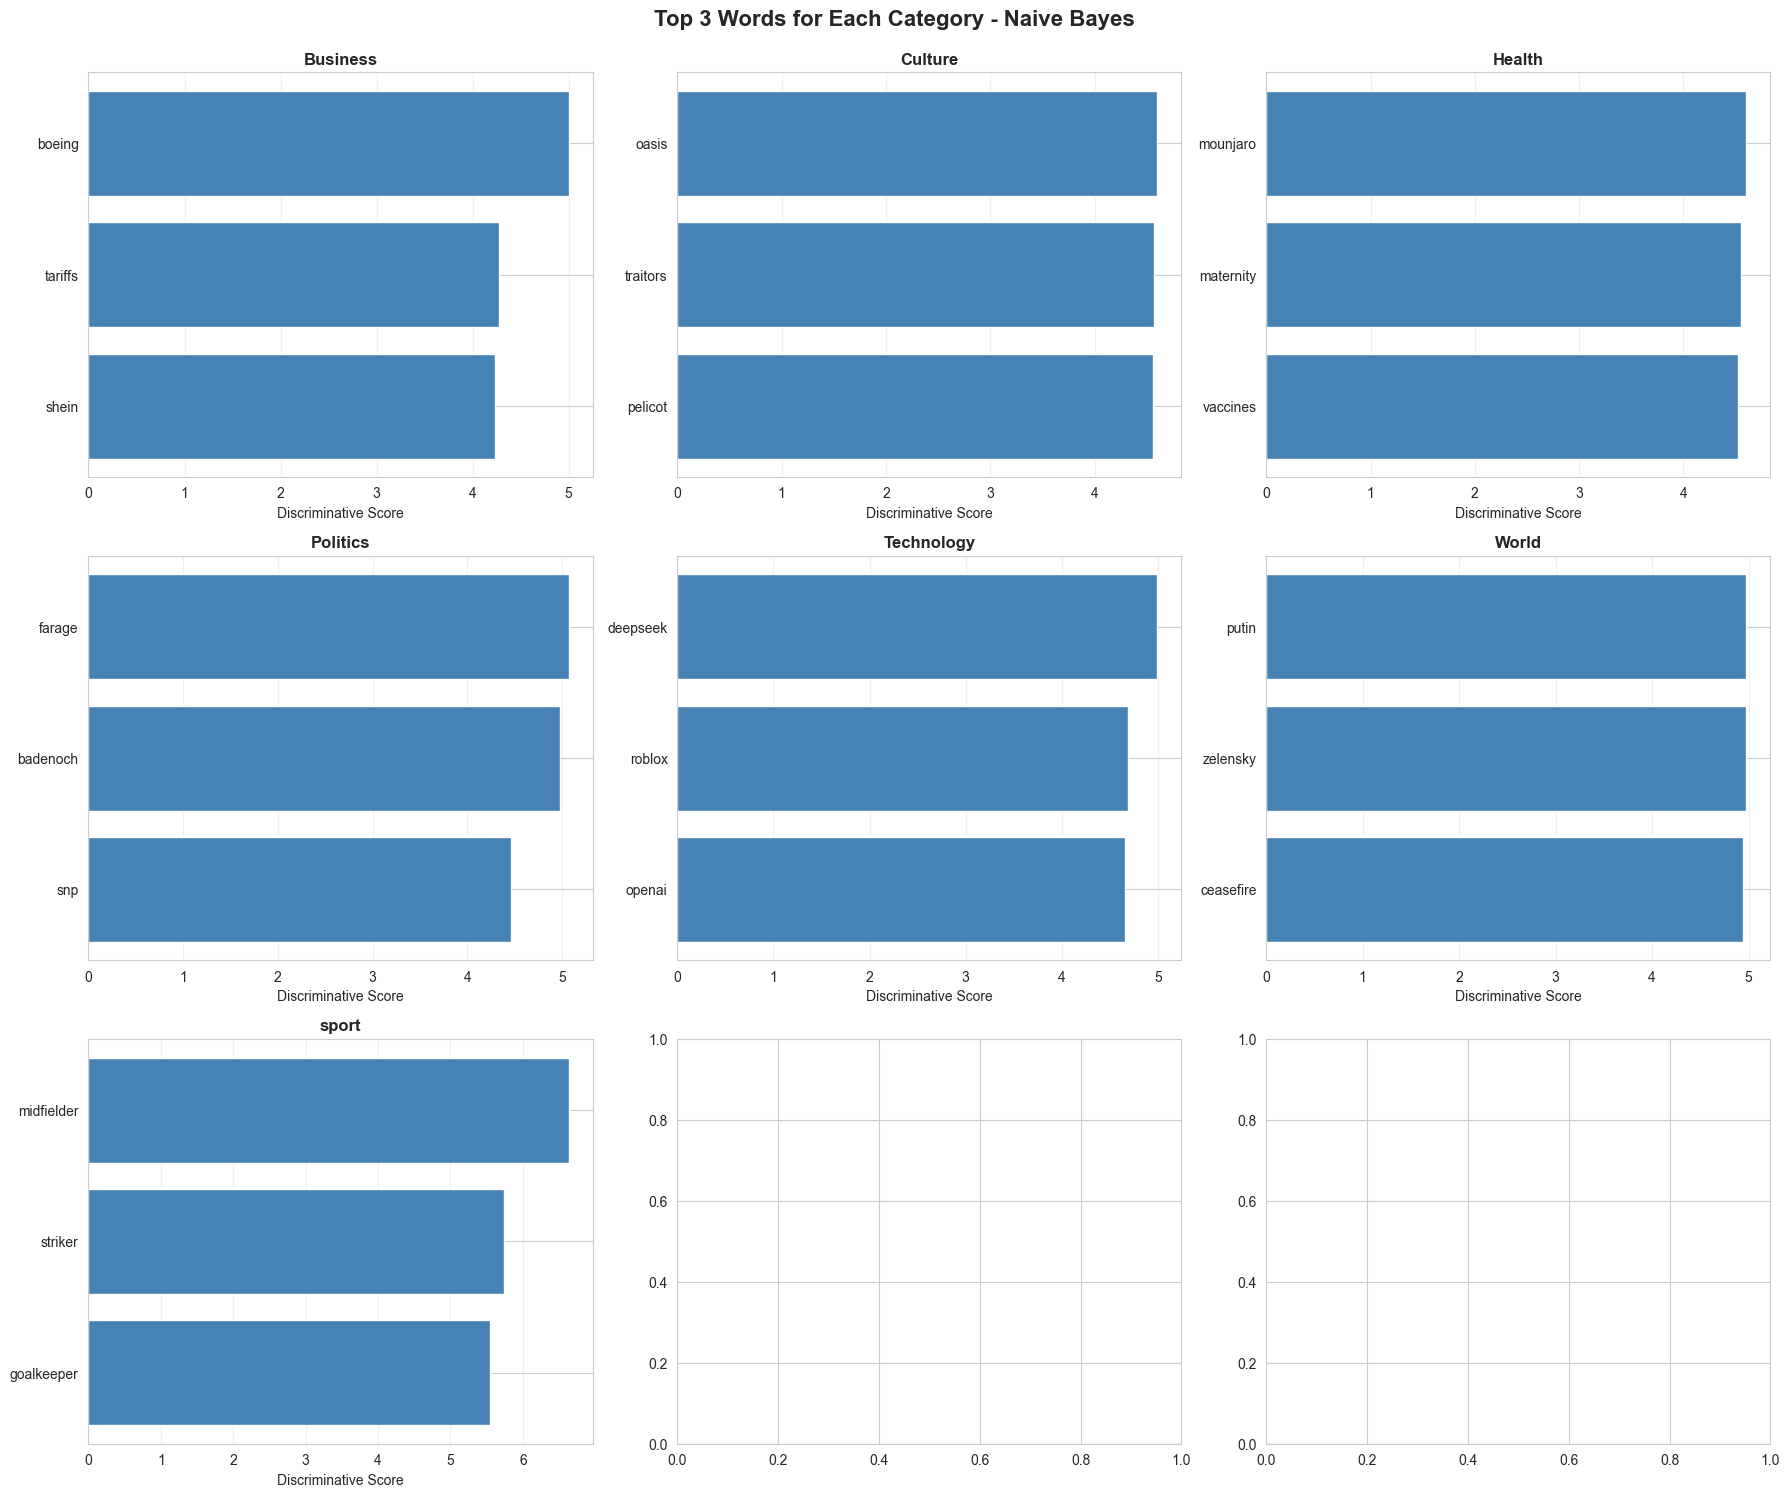

In [225]:
nb_vis_data = []
for category in sorted(nb_top_words.keys()):
    for word, score in nb_top_words[category]:
        nb_vis_data.append({
            'Category': category,
            'Word': word,
            'Score': score,
            'Model': 'Naive Bayes'
        })

nb_vis_df = pd.DataFrame(nb_vis_data)

fig, axes = plt.subplots(3, 3, figsize=(18, 15))
axes = axes.flatten()

categories = sorted(nb_top_words.keys())
for idx, category in enumerate(categories):
    cat_data = nb_vis_df[nb_vis_df['Category'] == category].sort_values('Score', ascending=True)
    
    axes[idx].barh(cat_data['Word'], cat_data['Score'], color='steelblue')
    axes[idx].set_title(f'{category}', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Discriminative Score', fontsize=10)
    axes[idx].grid(axis='x', alpha=0.3)

plt.suptitle('Top 3 Words for Each Category - Naive Bayes', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()


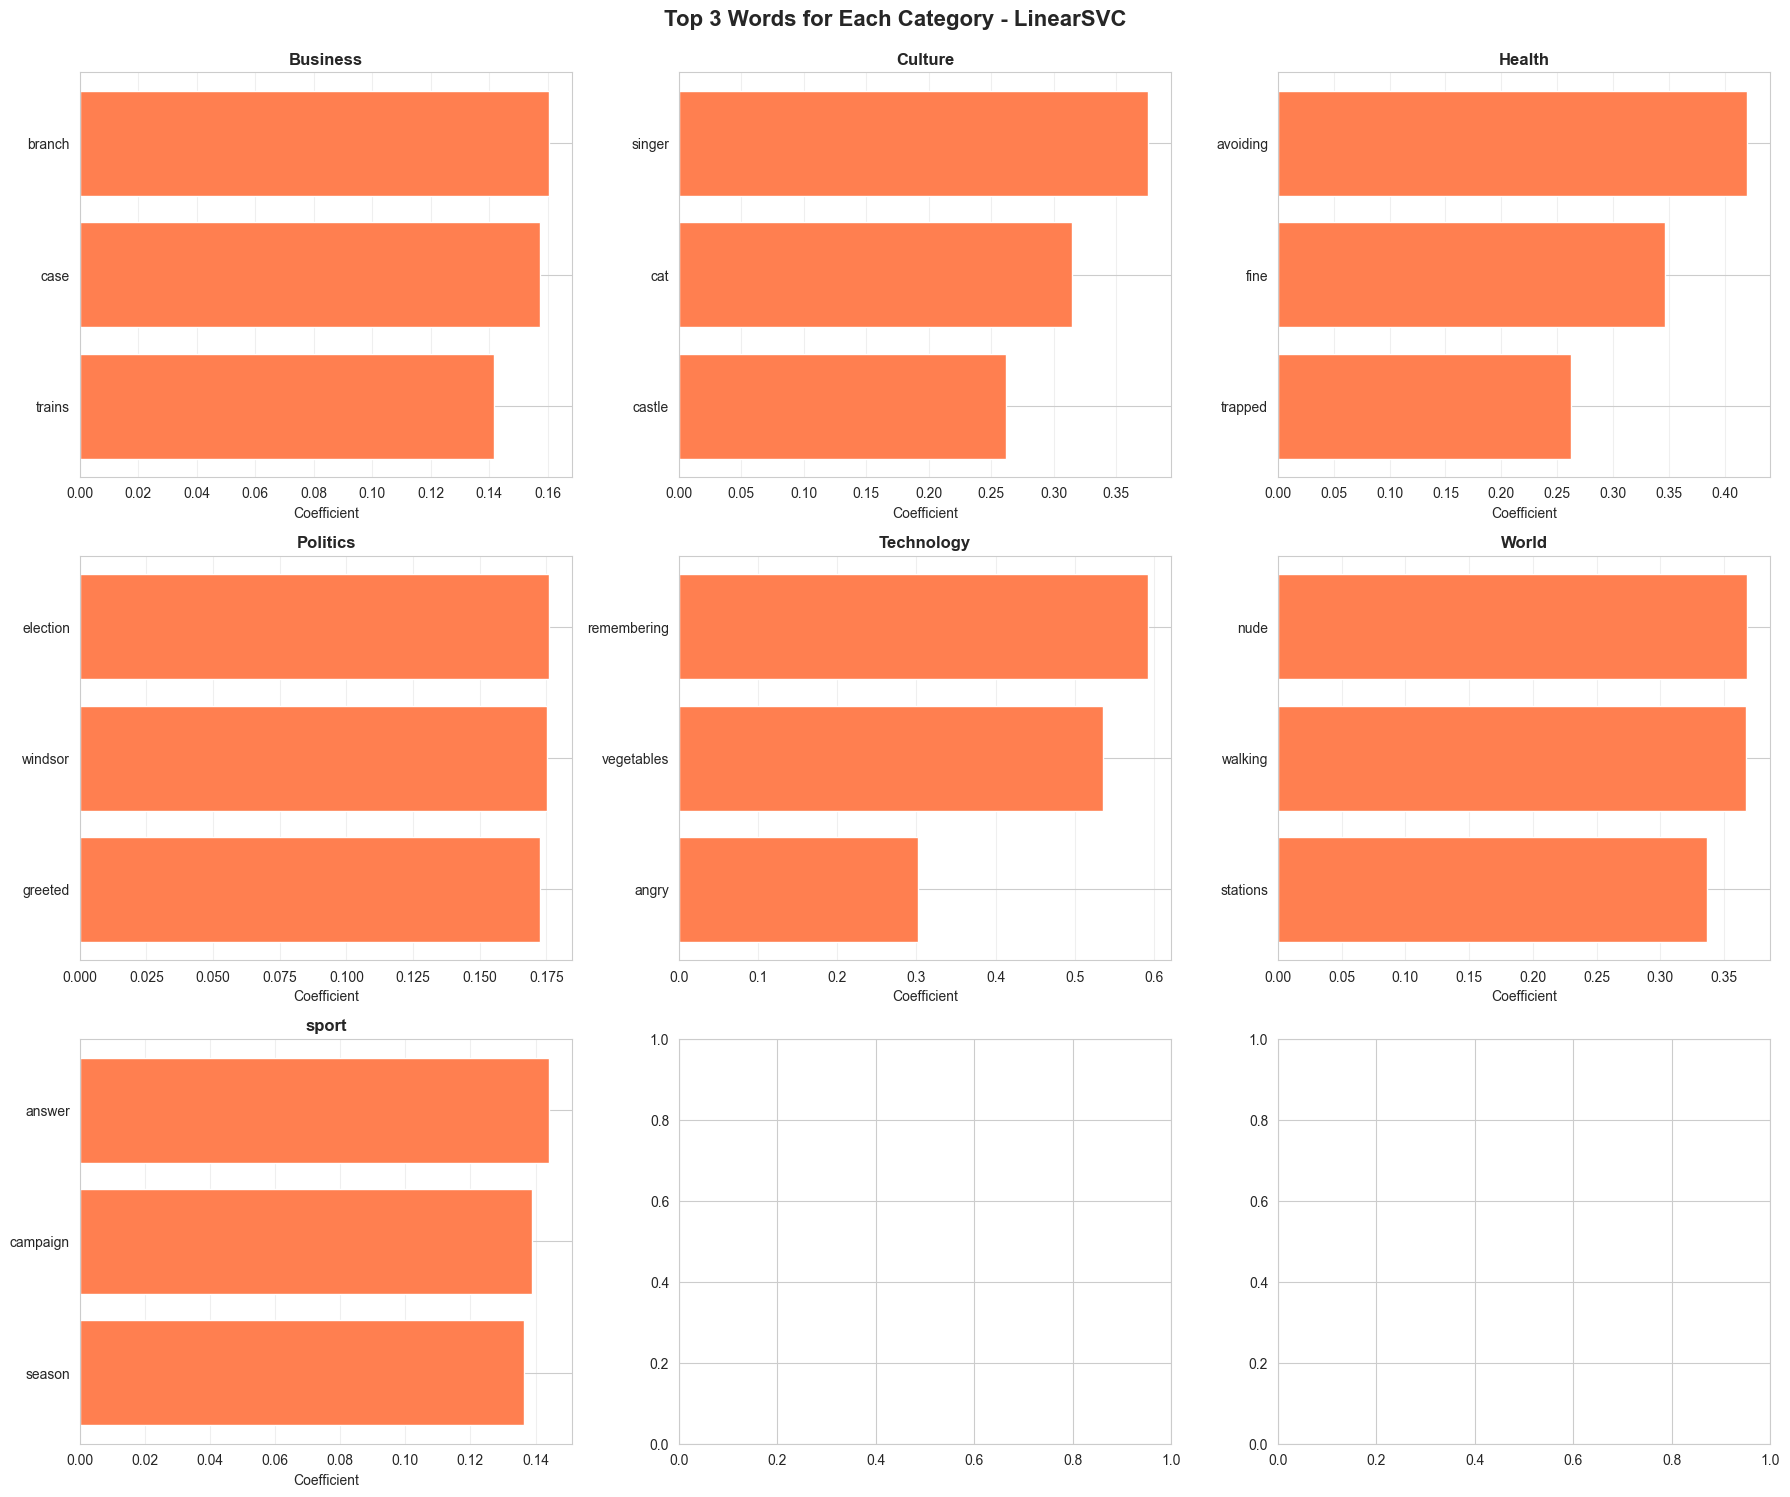

In [226]:
svc_vis_data = []
for category in sorted(svc_top_words.keys()):
    for word, score in svc_top_words[category]:
        svc_vis_data.append({
            'Category': category,
            'Word': word,
            'Score': score,
            'Model': 'LinearSVC'
        })

svc_vis_df = pd.DataFrame(svc_vis_data)


fig, axes = plt.subplots(3, 3, figsize=(18, 15))
axes = axes.flatten()

categories = sorted(svc_top_words.keys())
for idx, category in enumerate(categories):
    cat_data = svc_vis_df[svc_vis_df['Category'] == category].sort_values('Score', ascending=True)
    
    axes[idx].barh(cat_data['Word'], cat_data['Score'], color='coral')
    axes[idx].set_title(f'{category}', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Coefficient', fontsize=10)
    axes[idx].grid(axis='x', alpha=0.3)

plt.suptitle('Top 3 Words for Each Category - LinearSVC', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()


In [227]:
comparison_data = []
for category in sorted(set(list(nb_top_words.keys()) + list(svc_top_words.keys()))):
    nb_words = [w[0] for w in nb_top_words.get(category, [])]
    svc_words = [w[0] for w in svc_top_words.get(category, [])]
    
    comparison_data.append({
        'Category': category,
        'Naive Bayes - Top 3': ', '.join(nb_words) if nb_words else 'N/A',
        'LinearSVC - Top 3': ', '.join(svc_words) if svc_words else 'N/A',
        'Common Words': ', '.join(set(nb_words) & set(svc_words)) if (nb_words and svc_words) else 'None'
    })

comparison_df = pd.DataFrame(comparison_data)

styled_comparison = comparison_df.style.set_caption('Top 3 Words Comparison Between Models').set_table_styles([
    {'selector': 'caption', 'props': [('font-size', '14px'), ('font-weight', 'bold'), ('text-align', 'center')]},
    {'selector': 'th', 'props': [('background-color', '#4472C4'), ('color', 'white'), ('font-weight', 'bold'), ('text-align', 'center')]},
    {'selector': 'td', 'props': [('text-align', 'left'), ('padding', '8px')]}
]).set_properties(subset=['Category'], **{'font-weight': 'bold'})

display(styled_comparison)


,Category,Naive Bayes - Top 3,LinearSVC - Top 3,Common Words
0,Business,"boeing, tariffs, shein","branch, case, trains",
1,Culture,"oasis, traitors, pelicot","singer, cat, castle",
2,Health,"mounjaro, maternity, vaccines","avoiding, fine, trapped",
3,Politics,"farage, badenoch, snp","election, windsor, greeted",
4,Technology,"deepseek, roblox, openai","remembering, vegetables, angry",
5,World,"putin, zelensky, ceasefire","nude, walking, stations",
6,sport,"midfielder, striker, goalkeeper","answer, campaign, season",


In [228]:
summary_data = []
categories = sorted(set(list(nb_top_words.keys()) + list(svc_top_words.keys())))

for category in categories:
    nb_words = ', '.join([w[0] for w in nb_top_words.get(category, [])])
    svc_words = ', '.join([w[0] for w in svc_top_words.get(category, [])])
    
    summary_data.append({
        'Category': category,
        'Naive Bayes': nb_words if nb_words else 'N/A',
        'LinearSVC': svc_words if svc_words else 'N/A'
    })

summary_df = pd.DataFrame(summary_data)

styled_summary = summary_df.style.set_caption('Top 3 Most Important Words for Each Category - Naive Bayes vs LinearSVC').set_table_styles([
    {'selector': 'caption', 'props': [('font-size', '16px'), ('font-weight', 'bold'), ('text-align', 'center'), ('padding', '10px')]},
    {'selector': 'th', 'props': [('background-color', '#2E75B6'), ('color', 'white'), ('font-weight', 'bold'), ('text-align', 'center'), ('padding', '10px')]},
    {'selector': 'td', 'props': [('text-align', 'left'), ('padding', '8px')]}
]).set_properties(subset=['Category'], **{'font-weight': 'bold', 'background-color': '#E7F3FF'})

display(styled_summary)


,Category,Naive Bayes,LinearSVC
0,Business,"boeing, tariffs, shein","branch, case, trains"
1,Culture,"oasis, traitors, pelicot","singer, cat, castle"
2,Health,"mounjaro, maternity, vaccines","avoiding, fine, trapped"
3,Politics,"farage, badenoch, snp","election, windsor, greeted"
4,Technology,"deepseek, roblox, openai","remembering, vegetables, angry"
5,World,"putin, zelensky, ceasefire","nude, walking, stations"
6,sport,"midfielder, striker, goalkeeper","answer, campaign, season"


# CNN (Conv1D) with Word2Vec Embeddings


In [229]:
print("="*80)
print("CNN (CONV1D) WITH WORD2VEC EMBEDDINGS")
print("="*80)

# Create embedding matrix from Word2Vec model
print("\nCreating embedding matrix from Word2Vec model...")
embedding_matrix = np.zeros((max_words, w2v_model.vector_size))

# Map Word2Vec embeddings to tokenizer vocabulary
words_not_found = []
for word, i in tokenizer.word_index.items():
    if i < max_words:
        if word in w2v_model.wv:
            embedding_matrix[i] = w2v_model.wv[word]
        else:
            words_not_found.append(word)

print(f"✓ Embedding matrix created!")
print(f"Shape: {embedding_matrix.shape}")
print(f"Words not found in Word2Vec: {len(words_not_found)}")
print(f"Coverage: {(max_words - len(words_not_found)) / max_words * 100:.2f}%")


CNN (CONV1D) WITH WORD2VEC EMBEDDINGS

Creating embedding matrix from Word2Vec model...
✓ Embedding matrix created!
Shape: (10000, 100)
Words not found in Word2Vec: 70
Coverage: 99.30%


In [230]:
# Build CNN model with Word2Vec embeddings
print("\nBuilding CNN model with Word2Vec embeddings...")

cnn_w2v_model = Sequential([
    Embedding(
        max_words, 
        w2v_model.vector_size,  # Use Word2Vec embedding dimension (100)
        input_length=max_len,
        weights=[embedding_matrix],
        trainable=True  # Allow fine-tuning
    ),
    Conv1D(128, 5, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

cnn_w2v_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("✓ Model compiled!")
print(f"Model summary:")
cnn_w2v_model.summary()



Building CNN model with Word2Vec embeddings...
✓ Model compiled!
Model summary:


/opt/homebrew/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_10 (Embedding)        │ ?                      │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_9 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_9          │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,000,000 (3.81 MB)

 Trainable params: 1,000,000 (3.81 MB)

 Non-trainable params: 0 (0.00 B)

In [231]:
# Train CNN with Word2Vec
print("\nTraining CNN with Word2Vec embeddings...")
print("="*80)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

history_w2v = cnn_w2v_model.fit(
    X_train_padded,
    y_train_categorical,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

print("\n✓ Training complete!")



Training CNN with Word2Vec embeddings...
Epoch 1/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.1967 - loss: 2.5380 - val_accuracy: 0.5027 - val_loss: 1.3575
Epoch 2/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.4146 - loss: 1.4072 - val_accuracy: 0.6018 - val_loss: 1.1434
Epoch 3/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.4980 - loss: 1.2336 - val_accuracy: 0.6580 - val_loss: 0.9978
Epoch 4/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.5527 - loss: 1.0806 - val_accuracy: 0.6893 - val_loss: 0.8968
Epoch 5/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.6142 - loss: 0.9593 - val_accuracy: 0.7089 - val_loss: 0.8190
Epoch 6/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.6444 - loss: 0.8945 - val_accuracy: 0.7179 - val_loss: 0.7668
Epoch 7/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.6633 - loss: 0.8047 - val_accuracy: 0.7500 - val_loss: 0.7148
Epoch 8/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - 

In [232]:
# Evaluate CNN with Word2Vec
print("\n" + "="*80)
print("EVALUATING CNN WITH WORD2VEC")
print("="*80)

cnn_w2v_predictions_proba = cnn_w2v_model.predict(X_test_padded, verbose=0)
cnn_w2v_predictions_encoded = np.argmax(cnn_w2v_predictions_proba, axis=1)
cnn_w2v_predictions = label_encoder.inverse_transform(cnn_w2v_predictions_encoded)

display_classification_metrics(y_test, cnn_w2v_predictions, 'CNN (Word2Vec)')



EVALUATING CNN WITH WORD2VEC


,Category,Precision,Recall,F1-Score
0,Business,0.7135,0.6100,0.6577
1,Culture,0.7636,0.6300,0.6904
2,Health,0.7066,0.8550,0.7738
3,Politics,0.8439,0.7300,0.7828
4,Technology,0.6239,0.7050,0.6620
5,World,0.8019,0.8300,0.8157
6,sport,0.9074,0.9800,0.9423


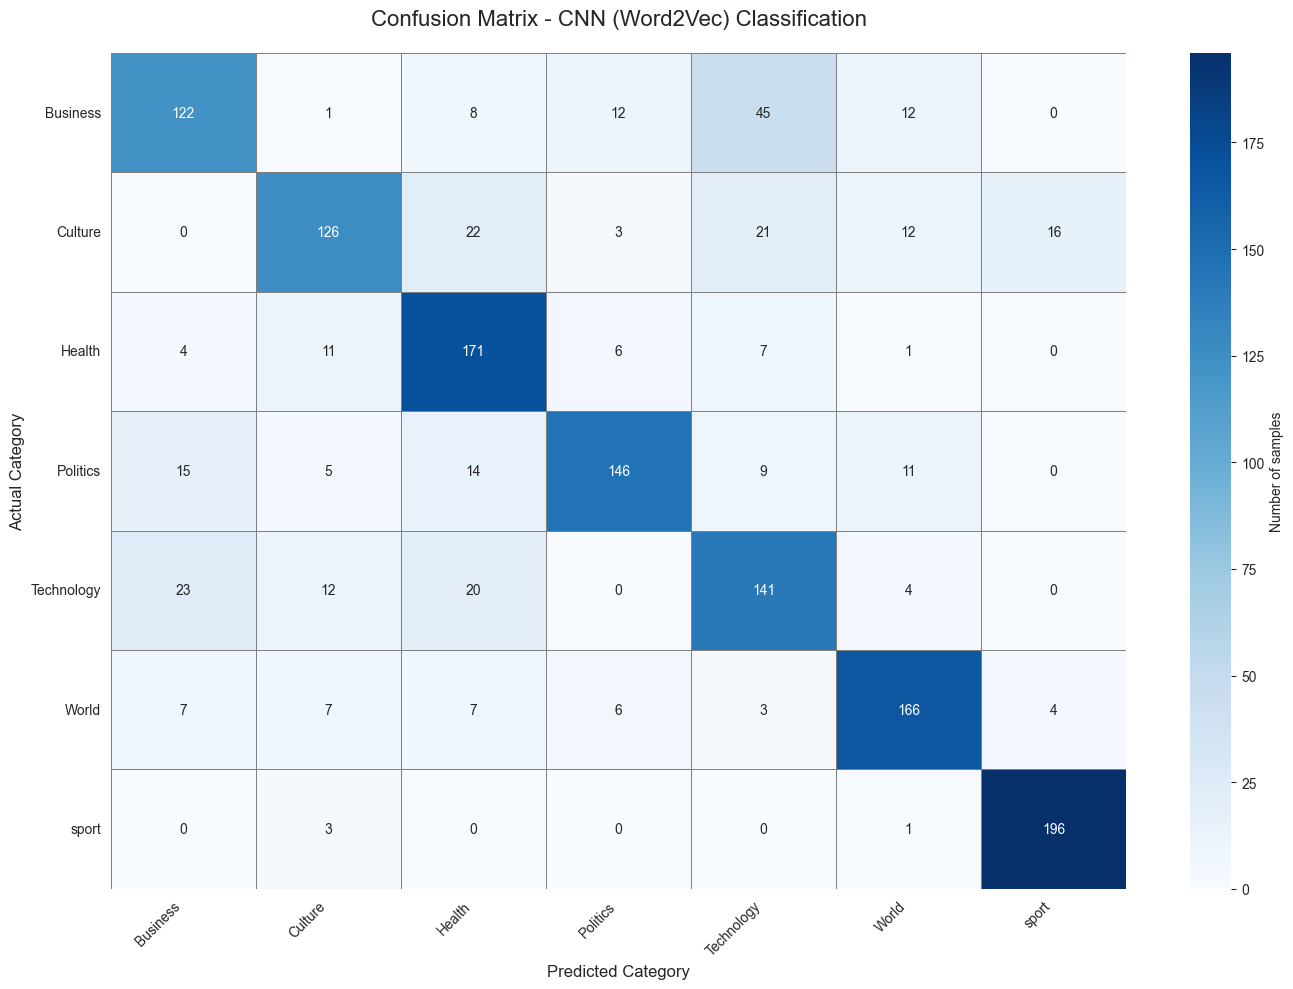

In [233]:
# Plot confusion matrix for CNN with Word2Vec
plot_confusion_matrix(y_test, cnn_w2v_predictions, title='Confusion Matrix - CNN (Word2Vec) Classification')


In [234]:
# Comprehensive CNN Testing with Multiple Embeddings and Dimensions
print("="*80)
print("COMPREHENSIVE CNN TESTING: MULTIPLE EMBEDDINGS AND DIMENSIONS")
print("="*80)
print("\nThis section will test:")
print("  - 3 different dimensions for Random Embeddings (64, 128, 256)")
print("  - 3 different dimensions for Word2Vec (50, 100, 200)")
print("  - 3 different dimensions for BERT (128, 256, 512)")
print("="*80)


COMPREHENSIVE CNN TESTING: MULTIPLE EMBEDDINGS AND DIMENSIONS

This section will test:
  - 3 different dimensions for Random Embeddings (64, 128, 256)
  - 3 different dimensions for Word2Vec (50, 100, 200)
  - 3 different dimensions for BERT (128, 256, 512)


In [235]:
# Prepare BERT embeddings
print("="*80)
print("PREPARING BERT EMBEDDINGS")
print("="*80)

print("\nLoading BERT model and tokenizer...")
bert_model_name = 'bert-base-uncased'
bert_tokenizer = AutoTokenizer.from_pretrained(bert_model_name)
bert_model = AutoModel.from_pretrained(bert_model_name)
bert_model.eval()  # Set to evaluation mode

print(f"✓ BERT model loaded: {bert_model_name}")

def get_bert_embeddings(texts, tokenizer, model, max_length=512, batch_size=32, use_token_level=True):
    """Extract BERT embeddings for a list of texts
    
    Args:
        use_token_level: If True, return token-level embeddings (for CNN). 
                        If False, return document-level [CLS] embeddings.
    """
    if use_token_level:
        # Token-level embeddings for CNN
        embeddings = []
        
        for i in range(0, len(texts), batch_size):
            batch_texts = texts[i:i+batch_size]
            
            # Tokenize
            encoded = tokenizer(
                batch_texts,
                padding='max_length',
                truncation=True,
                max_length=max_length,
                return_tensors='pt'
            )
            
            # Get token-level embeddings
            with torch.no_grad():
                outputs = model(**encoded)
                # Get all token embeddings (batch_size, seq_len, hidden_size)
                batch_embeddings = outputs.last_hidden_state.numpy()
            
            embeddings.extend(batch_embeddings)
        
        return np.array(embeddings)
    else:
        # Document-level [CLS] embeddings
        embeddings = []
        
        for i in range(0, len(texts), batch_size):
            batch_texts = texts[i:i+batch_size]
            
            # Tokenize
            encoded = tokenizer(
                batch_texts,
                padding=True,
                truncation=True,
                max_length=max_length,
                return_tensors='pt'
            )
            
            # Get embeddings
            with torch.no_grad():
                outputs = model(**encoded)
                # Use [CLS] token embedding (first token)
                batch_embeddings = outputs.last_hidden_state[:, 0, :].numpy()
            
            embeddings.extend(batch_embeddings)
        
        return np.array(embeddings)

print("\nExtracting BERT token-level embeddings for training set...")
X_train_bert = get_bert_embeddings(X_train, bert_tokenizer, bert_model, max_length=max_len, use_token_level=True)
print(f"✓ Training BERT embeddings shape: {X_train_bert.shape}")

print("\nExtracting BERT token-level embeddings for test set...")
X_test_bert = get_bert_embeddings(X_test, bert_tokenizer, bert_model, max_length=max_len, use_token_level=True)
print(f"✓ Test BERT embeddings shape: {X_test_bert.shape}")

print("\nBERT embeddings prepared!")


PREPARING BERT EMBEDDINGS

Loading BERT model and tokenizer...
✓ BERT model loaded: bert-base-uncased

Extracting BERT token-level embeddings for training set...
✓ Training BERT embeddings shape: (5600, 500, 768)

Extracting BERT token-level embeddings for test set...
✓ Test BERT embeddings shape: (1400, 500, 768)

BERT embeddings prepared!


In [236]:
# Function to create and train CNN with different embeddings
def train_cnn_with_embedding(embedding_type, embedding_dim, embedding_matrix=None, 
                            X_train_emb=None, X_test_emb=None, epochs=15, verbose=0):
    """
    Train CNN with specified embedding type and dimension
    
    Args:
        embedding_type: 'random', 'word2vec', or 'bert'
        embedding_dim: dimension of embeddings
        embedding_matrix: pre-computed embedding matrix (for word2vec)
        X_train_emb: pre-computed embeddings for training (for bert)
        X_test_emb: pre-computed embeddings for test (for bert)
    """
    
    if embedding_type == 'random':
        # Random embeddings - use tokenizer sequences
        model = Sequential([
            Embedding(max_words, embedding_dim, input_length=max_len),
            Conv1D(128, 5, activation='relu'),
            GlobalMaxPooling1D(),
            Dense(64, activation='relu'),
            Dropout(0.5),
            Dense(num_classes, activation='softmax')
        ])
        
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        
        early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=0)
        
        history = model.fit(
            X_train_padded, y_train_categorical,
            epochs=epochs,
            batch_size=32,
            validation_split=0.2,
            callbacks=[early_stopping],
            verbose=verbose
        )
        
        predictions_proba = model.predict(X_test_padded, verbose=0)
        predictions_encoded = np.argmax(predictions_proba, axis=1)
        predictions = label_encoder.inverse_transform(predictions_encoded)
        
    elif embedding_type == 'word2vec':
        # Word2Vec embeddings - use embedding matrix
        model = Sequential([
            Embedding(max_words, embedding_dim, input_length=max_len, 
                     weights=[embedding_matrix], trainable=True),
            Conv1D(128, 5, activation='relu'),
            GlobalMaxPooling1D(),
            Dense(64, activation='relu'),
            Dropout(0.5),
            Dense(num_classes, activation='softmax')
        ])
        
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        
        early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=0)
        
        history = model.fit(
            X_train_padded, y_train_categorical,
            epochs=epochs,
            batch_size=32,
            validation_split=0.2,
            callbacks=[early_stopping],
            verbose=verbose
        )
        
        predictions_proba = model.predict(X_test_padded, verbose=0)
        predictions_encoded = np.argmax(predictions_proba, axis=1)
        predictions = label_encoder.inverse_transform(predictions_encoded)
        
    elif embedding_type == 'bert':
        # BERT embeddings - token-level embeddings (samples, seq_len, hidden_size=768)
        # Reduce dimension using PCA if needed
        bert_hidden_size = X_train_emb.shape[2]  # BERT base has 768 dimensions
        
        if embedding_dim != bert_hidden_size:
            print(f"  Reducing BERT embeddings from {bert_hidden_size} to {embedding_dim} using PCA...")
            # Reshape for PCA: (samples * seq_len, hidden_size)
            n_samples, seq_len, hidden_size = X_train_emb.shape
            X_train_flat = X_train_emb.reshape(-1, hidden_size)
            X_test_flat = X_test_emb.reshape(-1, hidden_size)
            
            # Apply PCA
            pca = PCA(n_components=embedding_dim)
            X_train_reduced = pca.fit_transform(X_train_flat)
            X_test_reduced = pca.transform(X_test_flat)
            
            # Reshape back: (samples, seq_len, embedding_dim)
            X_train_bert_final = X_train_reduced.reshape(n_samples, seq_len, embedding_dim)
            X_test_bert_final = X_test_reduced.reshape(X_test_emb.shape[0], seq_len, embedding_dim)
        else:
            X_train_bert_final = X_train_emb
            X_test_bert_final = X_test_emb
        
        model = Sequential([
            Conv1D(128, 5, activation='relu', input_shape=(max_len, embedding_dim)),
            GlobalMaxPooling1D(),
            Dense(64, activation='relu'),
            Dropout(0.5),
            Dense(num_classes, activation='softmax')
        ])
        
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        
        early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=0)
        
        history = model.fit(
            X_train_bert_final, y_train_categorical,
            epochs=epochs,
            batch_size=32,
            validation_split=0.2,
            callbacks=[early_stopping],
            verbose=verbose
        )
        
        predictions_proba = model.predict(X_test_bert_final, verbose=0)
        predictions_encoded = np.argmax(predictions_proba, axis=1)
        predictions = label_encoder.inverse_transform(predictions_encoded)
    
    accuracy = accuracy_score(y_test, predictions) * 100
    
    return {
        'model': model,
        'predictions': predictions,
        'accuracy': accuracy,
        'history': history.history if 'history' in locals() else None
    }

print("✓ CNN training function defined!")


✓ CNN training function defined!


In [237]:
# Test Random Embeddings with different dimensions
print("="*80)
print("TESTING RANDOM EMBEDDINGS WITH DIFFERENT DIMENSIONS")
print("="*80)

random_dims = [64, 128, 256]
random_results = {}

for dim in random_dims:
    print(f"\n{'='*60}")
    print(f"Testing Random Embeddings - Dimension: {dim}")
    print(f"{'='*60}")
    
    result = train_cnn_with_embedding('random', dim, epochs=15, verbose=1)
    random_results[dim] = result
    
    print(f"✓ Completed - Accuracy: {result['accuracy']:.2f}%")

print(f"\n{'='*80}")
print("RANDOM EMBEDDINGS RESULTS SUMMARY")
print(f"{'='*80}")
for dim, result in random_results.items():
    print(f"Dimension {dim}: {result['accuracy']:.2f}%")


TESTING RANDOM EMBEDDINGS WITH DIFFERENT DIMENSIONS

Testing Random Embeddings - Dimension: 64
Epoch 1/15


/opt/homebrew/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.1954 - loss: 1.9088 - val_accuracy: 0.4491 - val_loss: 1.4681
Epoch 2/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.4828 - loss: 1.3882 - val_accuracy: 0.6455 - val_loss: 1.0139
Epoch 3/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.6673 - loss: 0.9551 - val_accuracy: 0.7143 - val_loss: 0.8026
Epoch 4/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.7728 - loss: 0.6956 - val_accuracy: 0.7366 - val_loss: 0.7196
Epoch 5/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.8608 - loss: 0.4575 - val_accuracy: 0.7670 - val_loss: 0.6561
Epoch 6/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.9324 - loss: 0.2675 - val_accuracy: 0.7670 - val_loss: 0.6454
Epoch 7/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.9549 - loss: 0.1730 - val_accuracy: 0.7795 - val_loss: 0.6618
Epoch 8/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.9758 - loss: 0.1096 - val_accuracy: 0.767

/opt/homebrew/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


140/140 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.2150 - loss: 1.8839 - val_accuracy: 0.5643 - val_loss: 1.3444
Epoch 2/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.5596 - loss: 1.2590 - val_accuracy: 0.7071 - val_loss: 0.8845
Epoch 3/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.7330 - loss: 0.7866 - val_accuracy: 0.7563 - val_loss: 0.6860
Epoch 4/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.8564 - loss: 0.4732 - val_accuracy: 0.7732 - val_loss: 0.6027
Epoch 5/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9403 - loss: 0.2468 - val_accuracy: 0.7875 - val_loss: 0.5853
Epoch 6/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - accuracy: 0.9782 - loss: 0.1182 - val_accuracy: 0.8045 - val_loss: 0.6212
Epoch 7/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.9825 - loss: 0.0954 - val_accuracy: 0.7920 - val_loss: 0.6404
Epoch 8/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.9895 - loss: 0.0697 - val_accuracy: 0.792

/opt/homebrew/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


140/140 ━━━━━━━━━━━━━━━━━━━━ 12s 76ms/step - accuracy: 0.2405 - loss: 1.8578 - val_accuracy: 0.5902 - val_loss: 1.1863
Epoch 2/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 11s 76ms/step - accuracy: 0.6347 - loss: 1.0608 - val_accuracy: 0.7214 - val_loss: 0.8033
Epoch 3/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 10s 71ms/step - accuracy: 0.8127 - loss: 0.6054 - val_accuracy: 0.7723 - val_loss: 0.6473
Epoch 4/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 10s 71ms/step - accuracy: 0.9082 - loss: 0.3289 - val_accuracy: 0.7955 - val_loss: 0.5988
Epoch 5/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 10s 71ms/step - accuracy: 0.9600 - loss: 0.1615 - val_accuracy: 0.7955 - val_loss: 0.6117
Epoch 6/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 11s 75ms/step - accuracy: 0.9833 - loss: 0.0873 - val_accuracy: 0.7875 - val_loss: 0.6433
Epoch 7/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 11s 82ms/step - accuracy: 0.9903 - loss: 0.0606 - val_accuracy: 0.7875 - val_loss: 0.6566
✓ Completed - Accuracy: 79.64%

RANDOM EMBEDDINGS RESULTS SUMMARY
Dimension 64: 79.07%
Dimension 128:

In [238]:
# Test Word2Vec with different dimensions
print("="*80)
print("TESTING WORD2VEC EMBEDDINGS WITH DIFFERENT DIMENSIONS")
print("="*80)

w2v_dims = [50, 100, 200]
w2v_results = {}

# Create Word2Vec models with different dimensions
print("\nTraining Word2Vec models with different dimensions...")
w2v_models = {}
for dim in w2v_dims:
    print(f"\nTraining Word2Vec with dimension {dim}...")
    w2v_model = Word2Vec(
        sentences=tokenized_train,
        vector_size=dim,
        window=5,
        min_count=2,
        workers=4,
        sg=0,  # CBOW
        epochs=10
    )
    w2v_models[dim] = w2v_model
    print(f"✓ Word2Vec model trained - Vocabulary size: {len(w2v_model.wv.key_to_index)}")

# Test each dimension
for dim in w2v_dims:
    print(f"\n{'='*60}")
    print(f"Testing Word2Vec Embeddings - Dimension: {dim}")
    print(f"{'='*60}")
    
    # Create embedding matrix
    embedding_matrix = np.zeros((max_words, dim))
    words_not_found = []
    w2v_model = w2v_models[dim]
    
    for word, i in tokenizer.word_index.items():
        if i < max_words:
            if word in w2v_model.wv:
                embedding_matrix[i] = w2v_model.wv[word]
            else:
                words_not_found.append(word)
    
    coverage = (max_words - len(words_not_found)) / max_words * 100
    print(f"Embedding matrix coverage: {coverage:.2f}%")
    
    result = train_cnn_with_embedding('word2vec', dim, embedding_matrix=embedding_matrix, epochs=15, verbose=1)
    w2v_results[dim] = result
    
    print(f"✓ Completed - Accuracy: {result['accuracy']:.2f}%")

print(f"\n{'='*80}")
print("WORD2VEC EMBEDDINGS RESULTS SUMMARY")
print(f"{'='*80}")
for dim, result in w2v_results.items():
    print(f"Dimension {dim}: {result['accuracy']:.2f}%")


TESTING WORD2VEC EMBEDDINGS WITH DIFFERENT DIMENSIONS

Training Word2Vec models with different dimensions...

Training Word2Vec with dimension 50...


Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'


✓ Word2Vec model trained - Vocabulary size: 77687

Training Word2Vec with dimension 100...


Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'


✓ Word2Vec model trained - Vocabulary size: 77687

Training Word2Vec with dimension 200...


Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'


✓ Word2Vec model trained - Vocabulary size: 77687

Testing Word2Vec Embeddings - Dimension: 50
Embedding matrix coverage: 99.30%
Epoch 1/15


/opt/homebrew/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.2360 - loss: 2.7037 - val_accuracy: 0.4509 - val_loss: 1.4777
Epoch 2/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.4058 - loss: 1.4806 - val_accuracy: 0.5884 - val_loss: 1.2582
Epoch 3/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.4714 - loss: 1.3083 - val_accuracy: 0.6554 - val_loss: 1.0531
Epoch 4/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.5227 - loss: 1.2007 - val_accuracy: 0.6786 - val_loss: 0.9896
Epoch 5/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.5769 - loss: 1.0594 - val_accuracy: 0.6848 - val_loss: 0.9452
Epoch 6/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.6393 - loss: 0.9599 - val_accuracy: 0.7018 - val_loss: 0.8514
Epoch 7/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.6579 - loss: 0.8594 - val_accuracy: 0.7250 - val_loss: 0.7531
Epoch 8/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.6918 - loss: 0.8010 - val_accuracy: 0.728

/opt/homebrew/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


140/140 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.2389 - loss: 3.2325 - val_accuracy: 0.4223 - val_loss: 1.4980
Epoch 2/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.3864 - loss: 1.4848 - val_accuracy: 0.5589 - val_loss: 1.2789
Epoch 3/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.4851 - loss: 1.2931 - val_accuracy: 0.6241 - val_loss: 1.0572
Epoch 4/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.5462 - loss: 1.1257 - val_accuracy: 0.6643 - val_loss: 0.9281
Epoch 5/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.6121 - loss: 0.9932 - val_accuracy: 0.7089 - val_loss: 0.8536
Epoch 6/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.6343 - loss: 0.9163 - val_accuracy: 0.6973 - val_loss: 0.8624
Epoch 7/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.6750 - loss: 0.8277 - val_accuracy: 0.7036 - val_loss: 0.8241
Epoch 8/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.6798 - loss: 0.8152 - val_accuracy: 0.739

/opt/homebrew/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


140/140 ━━━━━━━━━━━━━━━━━━━━ 9s 60ms/step - accuracy: 0.2383 - loss: 2.6068 - val_accuracy: 0.5616 - val_loss: 1.2630
Epoch 2/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 8s 57ms/step - accuracy: 0.4697 - loss: 1.3481 - val_accuracy: 0.6571 - val_loss: 0.9891
Epoch 3/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 8s 57ms/step - accuracy: 0.5992 - loss: 1.0520 - val_accuracy: 0.6875 - val_loss: 0.8648
Epoch 4/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - accuracy: 0.6541 - loss: 0.9261 - val_accuracy: 0.7063 - val_loss: 0.8296
Epoch 5/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 8s 57ms/step - accuracy: 0.6953 - loss: 0.8050 - val_accuracy: 0.7286 - val_loss: 0.7451
Epoch 6/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 9s 62ms/step - accuracy: 0.7250 - loss: 0.7024 - val_accuracy: 0.7402 - val_loss: 0.7263
Epoch 7/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 9s 61ms/step - accuracy: 0.7331 - loss: 0.6796 - val_accuracy: 0.7545 - val_loss: 0.6910
Epoch 8/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 8s 58ms/step - accuracy: 0.7749 - loss: 0.5729 - val_accuracy: 0.735

In [239]:
# Test BERT with different dimensions
print("="*80)
print("TESTING BERT EMBEDDINGS WITH DIFFERENT DIMENSIONS")
print("="*80)

bert_dims = [128, 256, 512]
bert_results = {}

for dim in bert_dims:
    print(f"\n{'='*60}")
    print(f"Testing BERT Embeddings - Dimension: {dim}")
    print(f"{'='*60}")
    
    result = train_cnn_with_embedding('bert', dim, 
                                     X_train_emb=X_train_bert, 
                                     X_test_emb=X_test_bert, 
                                     epochs=15, verbose=1)
    bert_results[dim] = result
    
    print(f"✓ Completed - Accuracy: {result['accuracy']:.2f}%")

print(f"\n{'='*80}")
print("BERT EMBEDDINGS RESULTS SUMMARY")
print(f"{'='*80}")
for dim, result in bert_results.items():
    print(f"Dimension {dim}: {result['accuracy']:.2f}%")


TESTING BERT EMBEDDINGS WITH DIFFERENT DIMENSIONS

Testing BERT Embeddings - Dimension: 128
  Reducing BERT embeddings from 768 to 128 using PCA...


/opt/homebrew/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.3240 - loss: 2.5259 - val_accuracy: 0.7420 - val_loss: 0.7865
Epoch 2/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.6941 - loss: 0.8505 - val_accuracy: 0.7786 - val_loss: 0.6335
Epoch 3/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.7629 - loss: 0.6519 - val_accuracy: 0.7946 - val_loss: 0.5696
Epoch 4/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.8142 - loss: 0.5295 - val_accuracy: 0.7839 - val_loss: 0.5607
Epoch 5/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.8474 - loss: 0.4347 - val_accuracy: 0.7991 - val_loss: 0.5455
Epoch 6/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.8646 - loss: 0.3898 - val_accuracy: 0.8036 - val_loss: 0.5331
Epoch 7/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.8946 - loss: 0.3109 - val_accuracy: 0.8009 - val_loss: 0.5351
Epoch 8/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.9151 - loss: 0.2688 - val_accu

/opt/homebrew/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 10s 65ms/step - accuracy: 0.3862 - loss: 2.3090 - val_accuracy: 0.7482 - val_loss: 0.7371
Epoch 2/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step - accuracy: 0.7439 - loss: 0.7254 - val_accuracy: 0.7920 - val_loss: 0.5787
Epoch 3/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 8s 54ms/step - accuracy: 0.8366 - loss: 0.4904 - val_accuracy: 0.7920 - val_loss: 0.5805
Epoch 4/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step - accuracy: 0.8612 - loss: 0.4051 - val_accuracy: 0.8152 - val_loss: 0.5170
Epoch 5/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 7s 50ms/step - accuracy: 0.8999 - loss: 0.3051 - val_accuracy: 0.8089 - val_loss: 0.5350
Epoch 6/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - accuracy: 0.9292 - loss: 0.2119 - val_accuracy: 0.8188 - val_loss: 0.5324
Epoch 7/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 8s 58ms/step - accuracy: 0.9447 - loss: 0.1736 - val_accuracy: 0.8188 - val_loss: 0.5454
✓ Completed - Accuracy: 83.79%

Testing BERT Embeddings - Dimension: 512
  Reducing BERT embeddi

/opt/homebrew/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 22s 142ms/step - accuracy: 0.4280 - loss: 1.6926 - val_accuracy: 0.7759 - val_loss: 0.6836
Epoch 2/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 13s 91ms/step - accuracy: 0.7921 - loss: 0.6132 - val_accuracy: 0.7911 - val_loss: 0.5940
Epoch 3/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 14s 97ms/step - accuracy: 0.8491 - loss: 0.4248 - val_accuracy: 0.8036 - val_loss: 0.5299
Epoch 4/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 15s 106ms/step - accuracy: 0.9040 - loss: 0.2998 - val_accuracy: 0.8241 - val_loss: 0.5245
Epoch 5/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 13s 95ms/step - accuracy: 0.9348 - loss: 0.2079 - val_accuracy: 0.8196 - val_loss: 0.5435
Epoch 6/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 13s 89ms/step - accuracy: 0.9543 - loss: 0.1493 - val_accuracy: 0.8143 - val_loss: 0.5902
Epoch 7/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 13s 90ms/step - accuracy: 0.9588 - loss: 0.1287 - val_accuracy: 0.7973 - val_loss: 0.6246
✓ Completed - Accuracy: 82.86%

BERT EMBEDDINGS RESULTS SUMMARY
Dimension 128: 83.36%
Di

COMPREHENSIVE COMPARISON: ALL EMBEDDINGS AND DIMENSIONS


,Embedding Type,Dimension,Accuracy (%)
7,BERT,256,83.79%
6,BERT,128,83.36%
8,BERT,512,82.86%
1,Random,128,80.50%
2,Random,256,79.64%
0,Random,64,79.07%
3,Word2Vec,50,78.00%
5,Word2Vec,200,77.93%
4,Word2Vec,100,76.21%


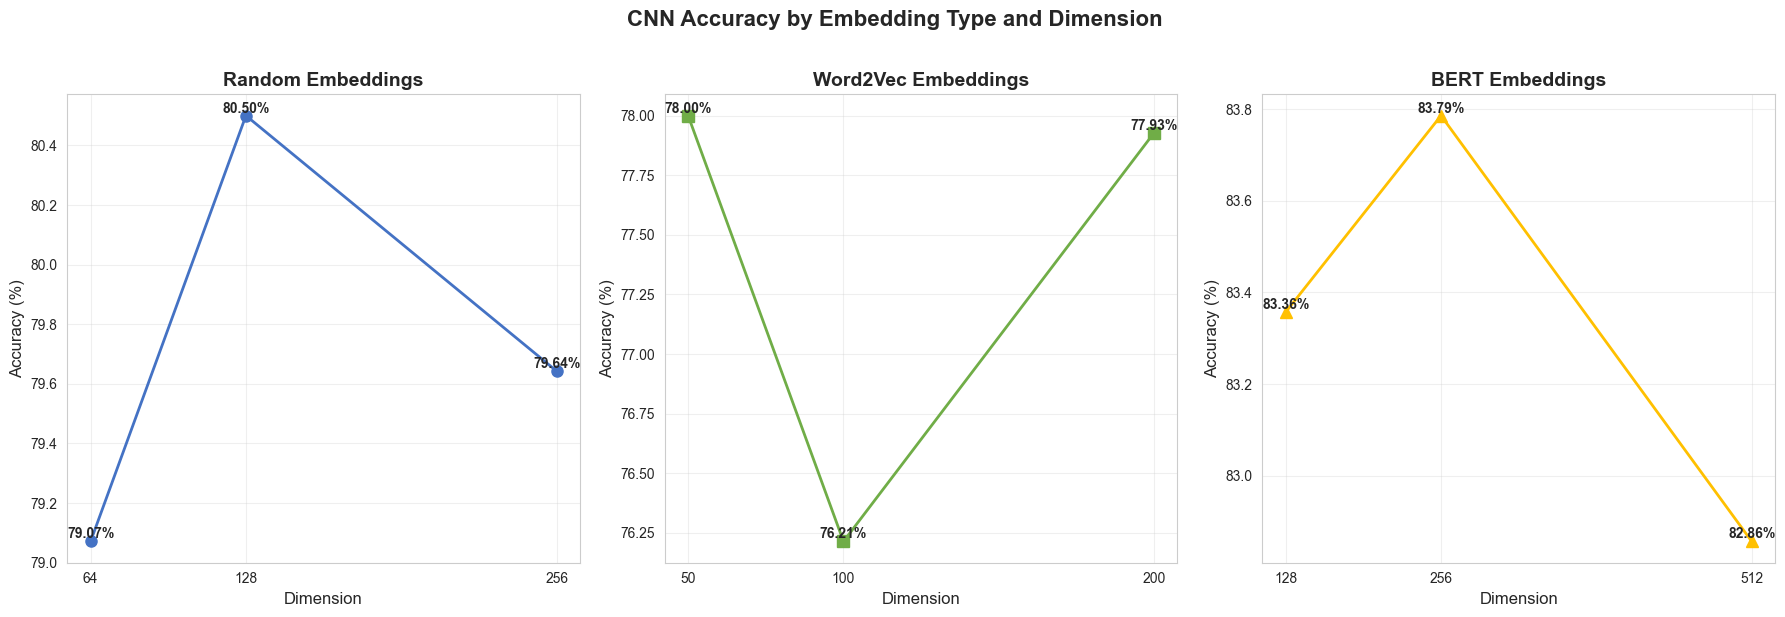

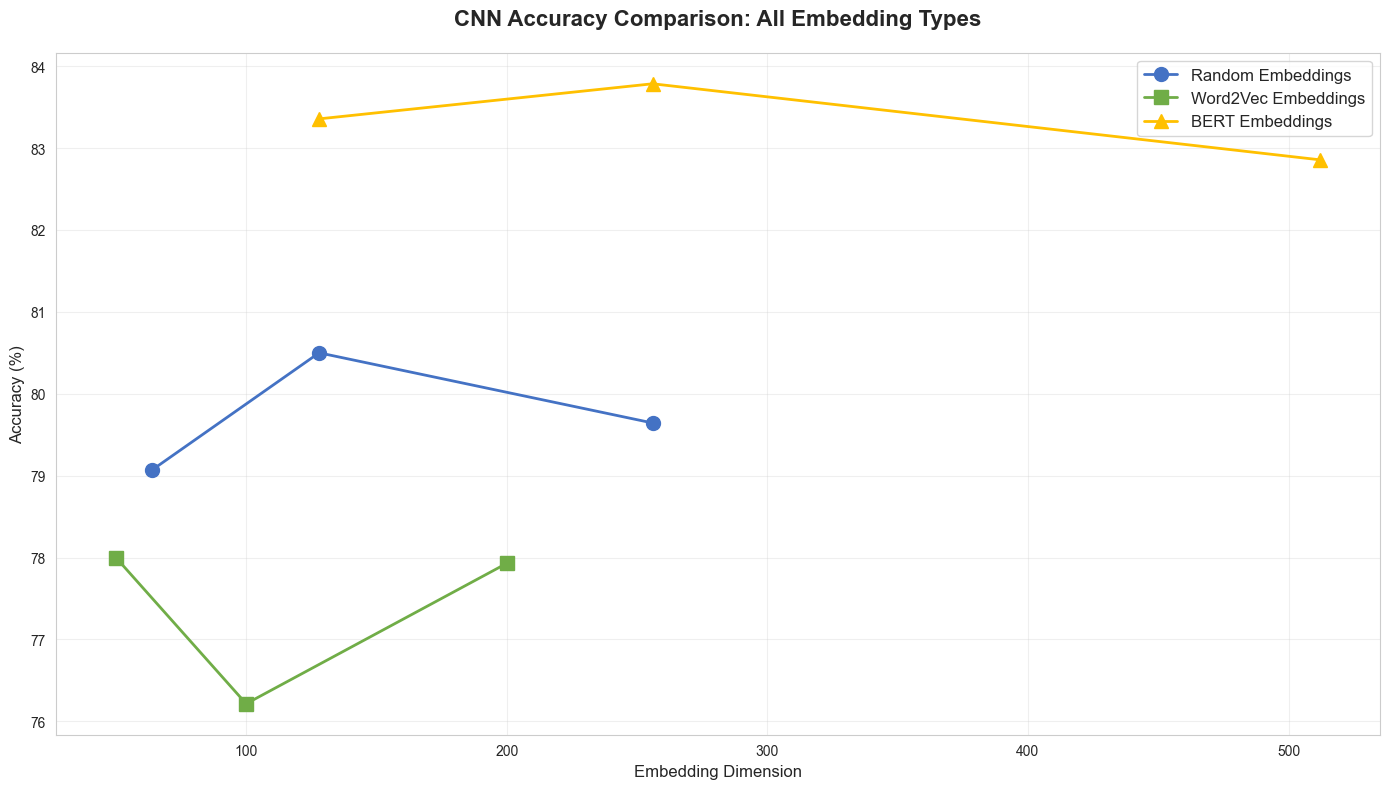


SUMMARY
🏆 Best Model: BERT (Dimension 256)
   Accuracy: 83.79%

Top 3 Models:
  8. BERT (Dim 256): 83.79%
  7. BERT (Dim 128): 83.36%
  9. BERT (Dim 512): 82.86%


In [240]:
# Comprehensive Comparison of All Results
print("="*80)
print("COMPREHENSIVE COMPARISON: ALL EMBEDDINGS AND DIMENSIONS")
print("="*80)

# Prepare comparison data
comparison_data = []

# Random embeddings
for dim, result in random_results.items():
    comparison_data.append({
        'Embedding Type': 'Random',
        'Dimension': dim,
        'Accuracy (%)': result['accuracy']
    })

# Word2Vec embeddings
for dim, result in w2v_results.items():
    comparison_data.append({
        'Embedding Type': 'Word2Vec',
        'Dimension': dim,
        'Accuracy (%)': result['accuracy']
    })

# BERT embeddings
for dim, result in bert_results.items():
    comparison_data.append({
        'Embedding Type': 'BERT',
        'Dimension': dim,
        'Accuracy (%)': result['accuracy']
    })

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('Accuracy (%)', ascending=False)

# Display styled table
styled_comparison = comparison_df.style.format({
    'Accuracy (%)': '{:.2f}%',
    'Dimension': '{:.0f}'
}).background_gradient(subset=['Accuracy (%)'], cmap='YlGnBu', 
                      vmin=comparison_df['Accuracy (%)'].min(),
                      vmax=comparison_df['Accuracy (%)'].max()).set_caption(
    'CNN: Comprehensive Comparison - All Embeddings and Dimensions').set_table_styles([
    {'selector': 'caption', 'props': [('font-size', '16px'), ('font-weight', 'bold'), ('text-align', 'center')]},
    {'selector': 'th', 'props': [('background-color', '#4472C4'), ('color', 'white'), ('font-weight', 'bold'), ('text-align', 'center')]},
    {'selector': 'td', 'props': [('text-align', 'center')]}
])

display(styled_comparison)

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Random embeddings
random_dims_list = [dim for dim in random_dims]
random_accs = [random_results[dim]['accuracy'] for dim in random_dims_list]
axes[0].plot(random_dims_list, random_accs, marker='o', linewidth=2, markersize=8, color='#4472C4')
axes[0].set_title('Random Embeddings', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Dimension', fontsize=12)
axes[0].set_ylabel('Accuracy (%)', fontsize=12)
axes[0].grid(True, alpha=0.3)
axes[0].set_xticks(random_dims_list)
for dim, acc in zip(random_dims_list, random_accs):
    axes[0].text(dim, acc, f'{acc:.2f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Word2Vec embeddings
w2v_dims_list = [dim for dim in w2v_dims]
w2v_accs = [w2v_results[dim]['accuracy'] for dim in w2v_dims_list]
axes[1].plot(w2v_dims_list, w2v_accs, marker='s', linewidth=2, markersize=8, color='#70AD47')
axes[1].set_title('Word2Vec Embeddings', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Dimension', fontsize=12)
axes[1].set_ylabel('Accuracy (%)', fontsize=12)
axes[1].grid(True, alpha=0.3)
axes[1].set_xticks(w2v_dims_list)
for dim, acc in zip(w2v_dims_list, w2v_accs):
    axes[1].text(dim, acc, f'{acc:.2f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')

# BERT embeddings
bert_dims_list = [dim for dim in bert_dims]
bert_accs = [bert_results[dim]['accuracy'] for dim in bert_dims_list]
axes[2].plot(bert_dims_list, bert_accs, marker='^', linewidth=2, markersize=8, color='#FFC000')
axes[2].set_title('BERT Embeddings', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Dimension', fontsize=12)
axes[2].set_ylabel('Accuracy (%)', fontsize=12)
axes[2].grid(True, alpha=0.3)
axes[2].set_xticks(bert_dims_list)
for dim, acc in zip(bert_dims_list, bert_accs):
    axes[2].text(dim, acc, f'{acc:.2f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.suptitle('CNN Accuracy by Embedding Type and Dimension', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Combined visualization
plt.figure(figsize=(14, 8))
plt.plot(random_dims_list, random_accs, marker='o', linewidth=2, markersize=10, 
         label='Random Embeddings', color='#4472C4')
plt.plot(w2v_dims_list, w2v_accs, marker='s', linewidth=2, markersize=10, 
         label='Word2Vec Embeddings', color='#70AD47')
plt.plot(bert_dims_list, bert_accs, marker='^', linewidth=2, markersize=10, 
         label='BERT Embeddings', color='#FFC000')

plt.title('CNN Accuracy Comparison: All Embedding Types', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Embedding Dimension', fontsize=12)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.legend(fontsize=12, loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Summary
print(f"\n{'='*80}")
print("SUMMARY")
print(f"{'='*80}")
best_result = comparison_df.iloc[0]
print(f"🏆 Best Model: {best_result['Embedding Type']} (Dimension {best_result['Dimension']:.0f})")
print(f"   Accuracy: {best_result['Accuracy (%)']:.2f}%")
print(f"\nTop 3 Models:")
for idx, row in comparison_df.head(3).iterrows():
    print(f"  {idx+1}. {row['Embedding Type']} (Dim {row['Dimension']:.0f}): {row['Accuracy (%)']:.2f}%")
print(f"{'='*80}")


COMPREHENSIVE COMPARISON: ALL CNN VARIANTS


,Model,Accuracy (%),Embedding Type,Input Shape
0,CNN (Random Embeddings),80.07%,Random (128-dim),"(500, 128)"
1,CNN (Word2Vec Embeddings),76.29%,Pre-trained Word2Vec (100-dim),"(500, 100)"


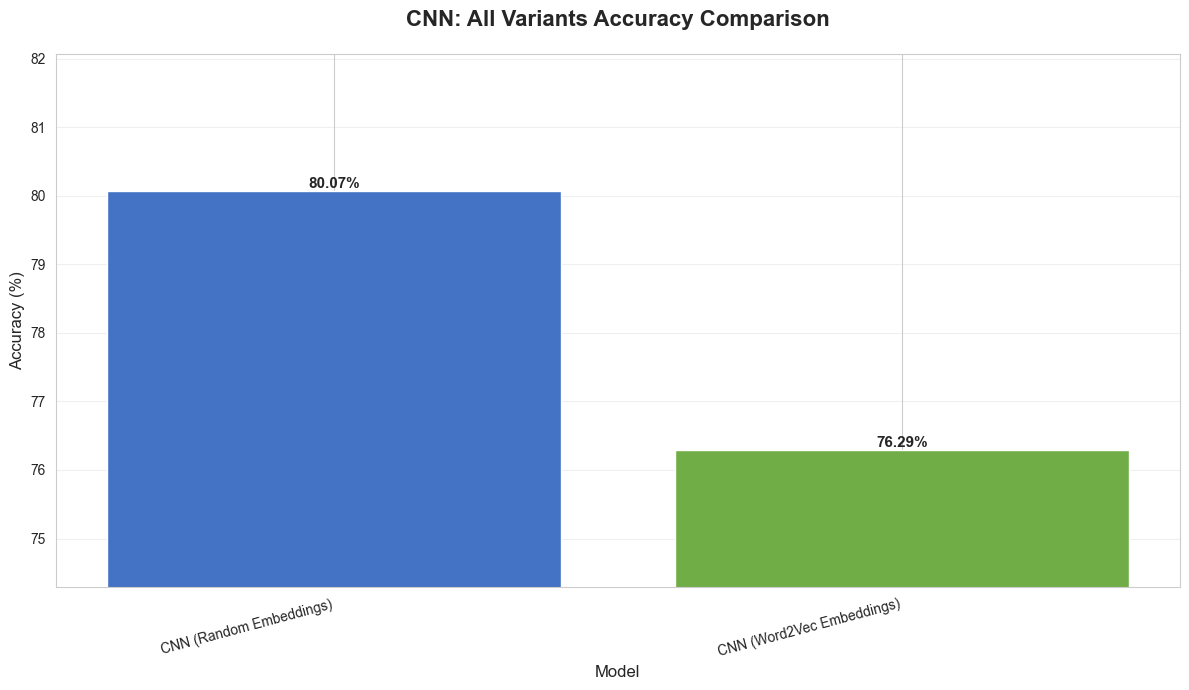


SUMMARY:
CNN (Random Embeddings) Accuracy:     80.07%
CNN (Word2Vec Embeddings) Accuracy:   76.29% (-3.79%)

🏆 Best Model: CNN (Random Embeddings) with 80.07% accuracy


In [241]:
# Comprehensive Comparison: All CNN Variants
print("="*80)
print("COMPREHENSIVE COMPARISON: ALL CNN VARIANTS")
print("="*80)

# Calculate accuracies
cnn_accuracy = accuracy_score(y_test, cnn_predictions) * 100
cnn_w2v_accuracy = accuracy_score(y_test, cnn_w2v_predictions) * 100

comparison_data = {
    'Model': [
        'CNN (Random Embeddings)', 
        'CNN (Word2Vec Embeddings)'
    ],
    'Accuracy (%)': [
        cnn_accuracy, 
        cnn_w2v_accuracy
    ],
    'Embedding Type': [
        'Random (128-dim)', 
        'Pre-trained Word2Vec (100-dim)'
    ],
    'Input Shape': [
        f'({max_len}, 128)', 
        f'({max_len}, 100)'
    ]
}

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('Accuracy (%)', ascending=False)

styled_comparison = comparison_df.style.format({
    'Accuracy (%)': '{:.2f}%'
}).background_gradient(subset=['Accuracy (%)'], cmap='YlGnBu', 
                      vmin=comparison_df['Accuracy (%)'].min(),
                      vmax=comparison_df['Accuracy (%)'].max()).set_caption(
    'CNN: All Variants Comparison').set_table_styles([
    {'selector': 'caption', 'props': [('font-size', '16px'), ('font-weight', 'bold'), ('text-align', 'center')]},
    {'selector': 'th', 'props': [('background-color', '#4472C4'), ('color', 'white'), ('font-weight', 'bold'), ('text-align', 'center')]},
    {'selector': 'td', 'props': [('text-align', 'center')]}
])

display(styled_comparison)

# Visualization
plt.figure(figsize=(12, 7))
colors = ['#4472C4', '#70AD47']
bars = plt.bar(comparison_df['Model'], comparison_df['Accuracy (%)'], color=colors)
plt.title('CNN: All Variants Accuracy Comparison', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.xlabel('Model', fontsize=12)
plt.xticks(rotation=15, ha='right')
plt.ylim([min(comparison_df['Accuracy (%)']) - 2, max(comparison_df['Accuracy (%)']) + 2])
plt.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}%',
             ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

# Summary
print(f"\n{'='*80}")
print("SUMMARY:")
print(f"{'='*80}")
print(f"CNN (Random Embeddings) Accuracy:     {cnn_accuracy:.2f}%")
print(f"CNN (Word2Vec Embeddings) Accuracy:   {cnn_w2v_accuracy:.2f}% ({cnn_w2v_accuracy - cnn_accuracy:+.2f}%)")
print(f"{'='*80}")

# Find best model
best_idx = comparison_df['Accuracy (%)'].idxmax()
best_model = comparison_df.loc[best_idx, 'Model']
best_accuracy = comparison_df.loc[best_idx, 'Accuracy (%)']
print(f"\n🏆 Best Model: {best_model} with {best_accuracy:.2f}% accuracy")
print(f"{'='*80}")


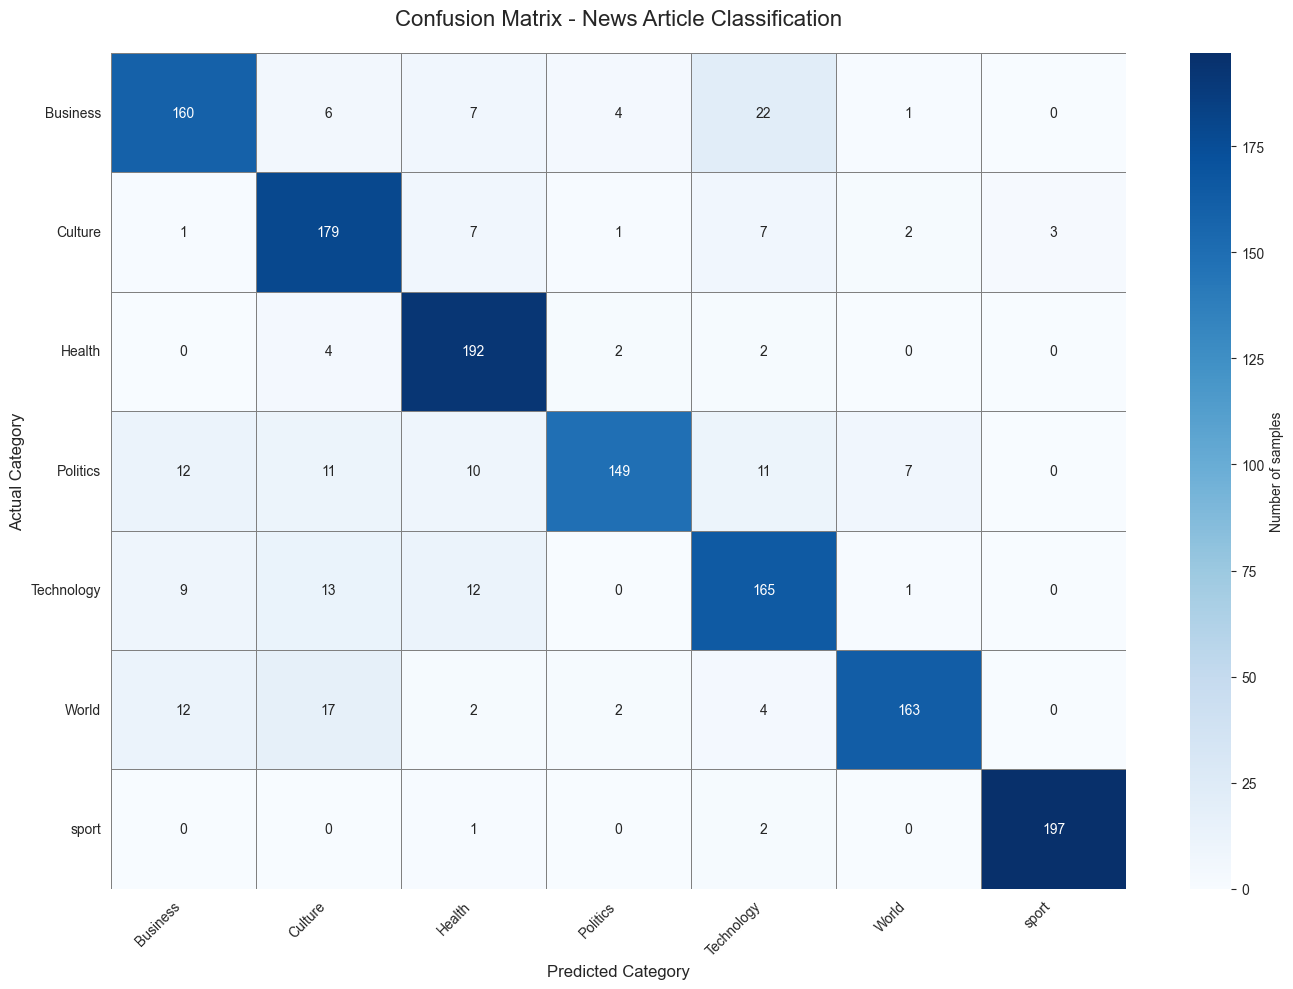

In [242]:
from sklearn.utils.multiclass import unique_labels

labels = list(unique_labels(y_test, predictions))
cm = confusion_matrix(y_test, predictions, labels=labels)
categories = labels

plt.figure(figsize=(14, 10))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=categories,
    yticklabels=categories,
    cbar_kws={'label': 'Number of samples'},
    linewidths=0.5,
    linecolor='gray'
)
plt.title('Confusion Matrix - News Article Classification', fontsize=16, pad=20)
plt.xlabel('Predicted Category', fontsize=12)
plt.ylabel('Actual Category', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

